In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [3]:
class BinaryDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
                    ds.append((get_x(), get_y(), 0))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [4]:
class GeneratedDataset(Dataset):
    def __init__(self, n):
        def construct_generated_dataset(k):
            S_new = []
            for _, i in enumerate(tqdm.tqdm(range(k))):
                pair = (get_x(), get_y())
                S_new.append(pair)
            np.random.shuffle(S_new)
            return S_new
        
        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y
        self.gen_ds = construct_generated_dataset(n)
    def __len__(self):
        return len(self.gen_ds)
    
    def __getitem__(self, idx):
        return (self.gen_ds[idx])

In [5]:
binary_ds=BinaryDataset(filepath="../data/aptamer_dataset.json")
n = len(binary_ds)
m = int(0.8*n) #length of train
binary_train = binary_ds[:m]
binary_val = binary_ds[m:]

In [6]:
# For the CDF functions, we need to generate a dataset of new examples
S_new = GeneratedDataset(10*m)

100%|██████████| 9460940/9460940 [15:18<00:00, 10302.10it/s]


## NN Model

In [7]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "LinearNet"
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [8]:
class LinearConv1d(nn.Module):
    def __init__(self):
        super(LinearConv1d, self).__init__()
        self.name = "LinearConv1d"
        
        self.cnn_apt_1 = nn.Conv1d(4, 10, 3) 
        self.cnn_apt_2 = nn.Conv1d(10, 25, 3) 
        self.cnn_apt_3 = nn.Conv1d(25, 50, 3) 
        self.cnn_apt_4 = nn.Conv1d(50, 100, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(200, 200)
        self.fc2 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = apt.permute(0, 2, 1)
        pep = pep.permute(0, 2, 1)
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        #print(apt.size())
        #print(pep.size())
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [9]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(ConvNetSimple, self).__init__()
        self.name = "ConvNetSimple"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 250, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 3)
        self.cnn_pep_3 = nn.Conv1d(100, 250, 1)
       
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(500, 550)
        self.fc2 = nn.Linear(550, 600)
        self.fc3 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        
        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)

        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
    
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc3(self.fc2(self.fc1(x)))
        x = torch.sigmoid(x)
        return x

In [10]:
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(ConvNetComplex, self).__init__()
        self.name = "ConvNetComplex"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 200, 3)
        self.cnn_apt_5 = nn.Conv1d(200, 400, 1)
        self.cnn_apt_6 = nn.Conv1d(400, 800, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)
        self.cnn_pep_3 = nn.Conv1d(100, 200, 1)
        self.cnn_pep_4 = nn.Conv1d(200, 400, 1)
        self.cnn_pep_5 = nn.Conv1d(400, 800, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(1600, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.relu(self.cnn_apt_1(apt))
        apt = self.relu(self.cnn_apt_2(apt))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))        
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))        

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.relu(self.cnn_pep_2(pep))
        pep = self.relu(self.cnn_pep_3(pep))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x
        

In [11]:
class SingleAlphabetNet(nn.Module):
    def __init__(self):
        super(SingleAlphabetNet, self).__init__()
        self.name = "SingleAlphabetNet"
        
        self.cnn_1 = nn.Conv1d(24, 25, 3) 
        self.cnn_2 = nn.Conv1d(25, 50, 3)
        self.cnn_3 = nn.Conv1d(50, 100, 3)
        self.cnn_4 = nn.Conv1d(100, 200, 3)
        self.cnn_5 = nn.Conv1d(200, 400, 1)
        self.cnn_6 = nn.Conv1d(400, 800, 1)
        
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(1600, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, pair):
        # pair input size [1, 48, 24]
        pair = pair.permute(0, 2, 1)
        
        pair = self.relu(self.cnn_1(pair))
        pair = self.relu(self.cnn_2(pair))
        pair = self.pool1(self.relu(self.cnn_3(pair)))
        pair = self.pool1(self.relu(self.cnn_4(pair)))
        pair = self.pool1(self.relu(self.cnn_5(pair)))        
        pair = self.pool1(self.relu(self.cnn_6(pair)))        

        pair = pair.view(-1, 1).T
        
        pair = self.fc2(self.fc1(pair))
        x = torch.sigmoid(pair)
        return x

In [12]:
class SingleAlphabetComplexNet(nn.Module):
    def __init__(self):
        super(SingleAlphabetComplexNet, self).__init__()
        self.name = "SingleAlphabetComplexNet"
        
        self.cnn_1 = nn.Conv1d(24, 50, 3) 
        self.cnn_2 = nn.Conv1d(50, 100, 3)
        self.cnn_3 = nn.Conv1d(100, 200, 3)
        self.cnn_4 = nn.Conv1d(200, 400, 3)
        self.cnn_5 = nn.Conv1d(400, 800, 3)
        self.cnn_6 = nn.Conv1d(800, 1000, 3, padding=2)
        self.cnn_7 = nn.Conv1d(1000, 800, 3, padding=2)
        self.cnn_8 = nn.Conv1d(800, 700, 3, padding=2)
        self.cnn_9 = nn.Conv1d(700, 500, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(500, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, pair):
        # pair input size [1, 48, 24]
        pair = pair.permute(0, 2, 1)
        
        pair = self.relu(self.cnn_1(pair))
        pair = self.relu(self.cnn_2(pair))
        pair = self.pool1(self.relu(self.cnn_3(pair)))
        pair = self.pool1(self.relu(self.cnn_4(pair)))
        pair = self.pool1(self.relu(self.cnn_5(pair)))        
        pair = self.pool1(self.relu(self.cnn_6(pair)))
        pair = self.pool1(self.relu(self.cnn_7(pair))) 
        pair = self.pool1(self.relu(self.cnn_8(pair)))
        pair = self.pool1(self.relu(self.cnn_9(pair))) 

        pair = pair.view(-1, 1).T
        
        pair = self.fc2(self.fc1(pair))
        x = torch.sigmoid(pair)
        return x

In [13]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [14]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        one_hot = np.zeros((len(apt) + len(pep), 24))
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            for _ in range(len(na_list)):
                idx = na_list.index(char)
                one_hot[i][idx] = 1
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            for _ in range(len(aa_list)):
                idx = aa_list.index(char) + len(na_list)
                one_hot[i+len(apt)][idx] = 1
        
        return one_hot       
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        one_hot = np.zeros((len(sequence), len(letters)))
        for i in range(len(sequence)):
            char = sequence[i]
            for _ in range(len(letters)):
                idx = letters.index(char)
                one_hot[i][idx] = 1
        return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = one_hot([apt, pep], single_alphabet=True)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[0], pair.shape[1]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        apt = one_hot(apt, seq_type='aptamer') #(40, 4)
        pep = one_hot(pep, seq_type='peptide') #(8, 20)
        apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[0], apt.shape[1]))).to(device) #(1, 40, 4)
        pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[0], pep.shape[1]))).to(device) #(1, 8, 20)
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name, model_id):
    plt.title("Training Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/loss.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name, model_id):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/accuracy.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    
    sns.distplot(train_gen_scores , color="skyblue", label='Generated Train Samples', ax=ax)
    sns.distplot(val_gen_scores, color='dodgerblue', label='Generated Validation Samples')
    sns.distplot(train_scores , color="lightcoral", label='Dataset Train Samples', ax=ax)
    sns.distplot(val_scores, color='red', label='Dataset Validation Samples', ax=ax)
    
    ax.set_title("Categorizing the output scores of the model")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/binary/%s/%s/histogram.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_test(test_score, iters, epoch, gamma, model_name, model_id):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/test_cdf.png' %(model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, iters, epoch, gamma, model_name, model_id):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" % iters)
    plt.title('Train CDF at epoch %d' %epoch+ ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

## Binary Classification

In [23]:
def classifier(model, 
               train, 
               val,
               lr,
               model_id,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None, 
               cdf=False):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=5e-3)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch'] + 1
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
        init_epoch = 0
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    iters, train_correct, val_correct = 0, 0, 0
    criterion = nn.BCELoss()
    optimizer = SGD(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.9) #Decays lr by gamma factor every step_size epochs. 
    
    # Keep track of the scores across four classes
    train_scores, train_gen_scores, val_scores, val_gen_scores = [], [], [], []
    # Used for the CDF (generated pair outputs)
    gen_outputs = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        full_epoch = epoch + init_epoch
        print("Starting epoch: %d" % full_epoch, " with learning rate: ", scheduler.get_lr())
        for i, (apt, pep, label) in enumerate(tqdm.tqdm(train)):
            model_name = model.name
            model.train()
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)
                
            if (train_score.item() >= 0.5 and label == 1.0) or (train_score.item() <= 0.5 and label == 0.0):
                train_correct += 1
            
            if label == 0.0:
                train_gen_scores.append(train_score.item())
            elif label == 1.0:
                train_scores.append(train_score.item())
                
            iters += 1
            train_loss = criterion(train_score, l) 
            total_train_loss += train_loss
            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            if single_alphabet:
                p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2], single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2])
                val_score = model(a_val, p_val)
            if (val_score.item() >= 0.5 and val[iters%(n-m)][2] == 1.0) or (val_score.item() <= 0.5 and val[iters%(n-m)][2] == 0.0):
                val_correct += 1
            
            if l_val.item() == 1.0:
                val_scores.append(val_score.item())
            if l_val.item() == 0.0:
                val_gen_scores.append(val_score.item())
            
            if cdf:
                #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
                for x, y in S_new[10*i:10*(i+1)]:
                    if single_alphabet:
                        p_val, l_val = convert(x, y, 0, single_alphabet=True)
                        gen_score = model(p_val)
                    else:
                        a_val, p_val, l_val = convert(x, y, 0)
                        gen_score = model(a_val, p_val)
                    gen_outputs.append(gen_score.item())

                # Generate CDF plots
                if len(train_scores) > 1000:
                    train_cdf = np.asarray(gen_outputs[-10000:] + train_scores[-1000:]) 
                    test_cdf = np.asarray(gen_outputs[-10000:] + val_scores[-1000:])
                else:
                    train_cdf = np.asarray(gen_outputs + train_scores) #combine train and unknown scores
                    test_cdf = np.asarray(gen_outputs + val_scores)
            
            val_loss = criterion(val_score, l_val) 
            total_val_loss += val_loss
            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))

            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name, model_id)
                plot_accuracy(iters, train_acc, val_acc, model_name, model_id)
                plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id)
                if cdf:
                    plot_ecdf_train(train_cdf, iters, full_epoch, lr, model_name, model_id)
                    plot_ecdf_test(test_cdf, iters, full_epoch, lr, model_name, model_id)
                
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) % full_epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) % full_epoch)
        scheduler.step()
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': full_epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
        
        # Clear unused gpu memory at the end of the epoch
        if device == torch.cuda:
            torch.cuda.empty_cache()

  0%|          | 18/946094 [00:00<1:28:23, 178.40it/s]

Reloading model:  SingleAlphabetComplexNet  at epoch:  18
Starting epoch: 18  with learning rate:  [0.1]


  5%|▌         | 49985/946094 [06:37<1:54:35, 130.34it/s]

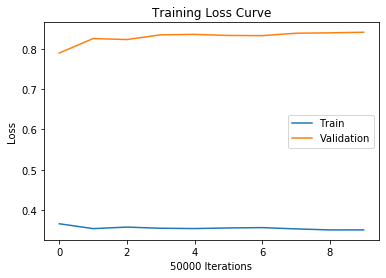

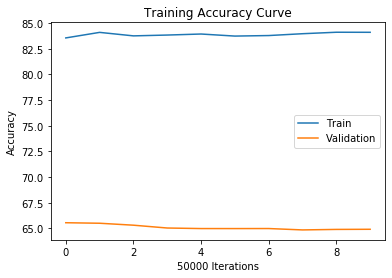

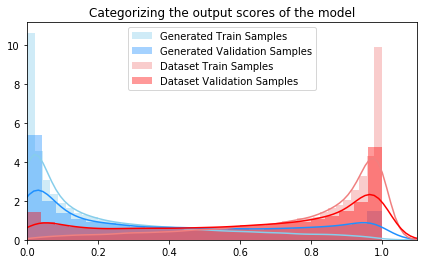

  5%|▌         | 50021/946094 [06:39<7:05:23, 35.11it/s] 

Training Accuracy at epoch 18: 84.108
Validation Accuracy epoch 18: 64.922


 11%|█         | 99985/946094 [13:19<2:28:47, 94.78it/s] 

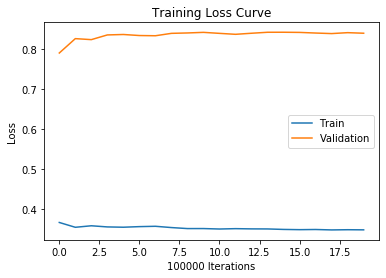

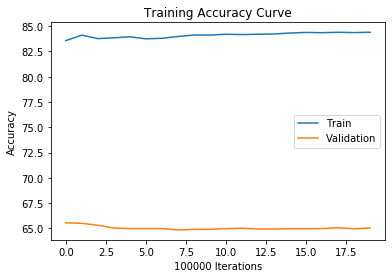

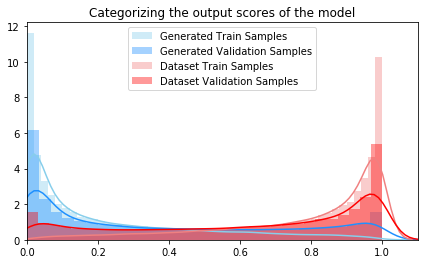

 11%|█         | 100021/946094 [13:24<14:54:18, 15.77it/s]

Training Accuracy at epoch 18: 84.39
Validation Accuracy epoch 18: 65.058


 16%|█▌        | 149984/946094 [20:01<1:24:29, 157.05it/s]

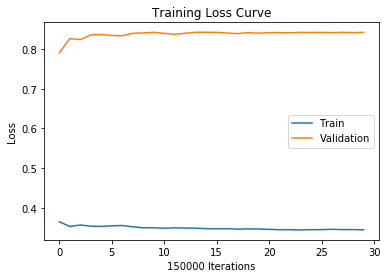

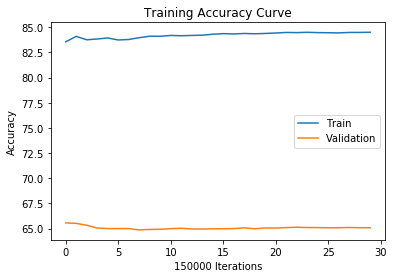

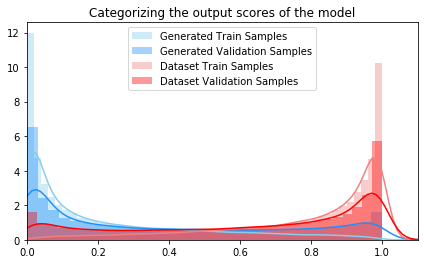

 16%|█▌        | 150002/946094 [20:04<11:25:19, 19.36it/s]

Training Accuracy at epoch 18: 84.51
Validation Accuracy epoch 18: 65.07733333333333


 21%|██        | 199984/946094 [26:42<1:41:20, 122.71it/s]

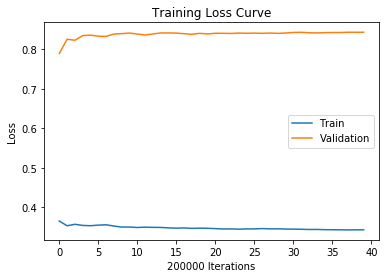

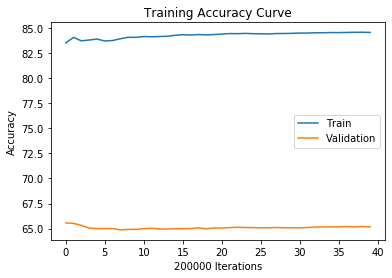

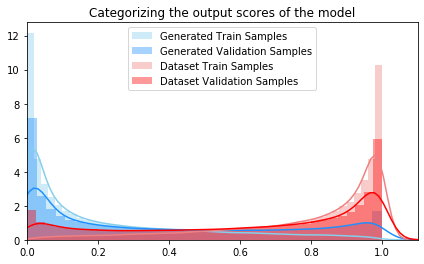

 21%|██        | 200016/946094 [26:46<11:43:00, 17.69it/s]

Training Accuracy at epoch 18: 84.6
Validation Accuracy epoch 18: 65.1685


 26%|██▋       | 249983/946094 [33:24<1:09:43, 166.41it/s]

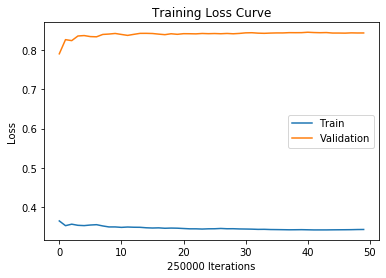

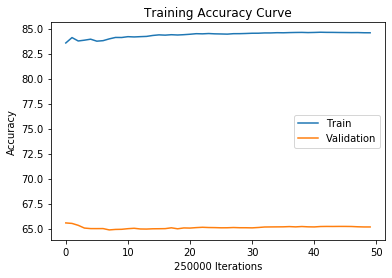

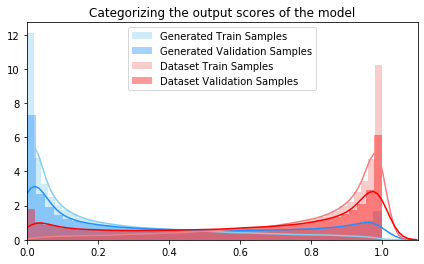

 26%|██▋       | 250017/946094 [33:28<9:37:34, 20.09it/s] 

Training Accuracy at epoch 18: 84.5796
Validation Accuracy epoch 18: 65.156


 32%|███▏      | 299994/946094 [40:09<1:13:39, 146.20it/s]

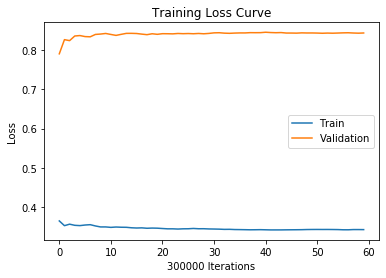

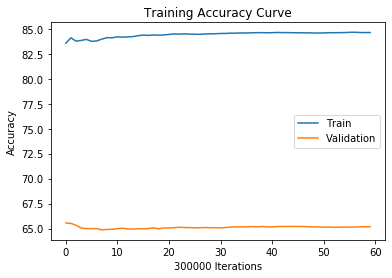

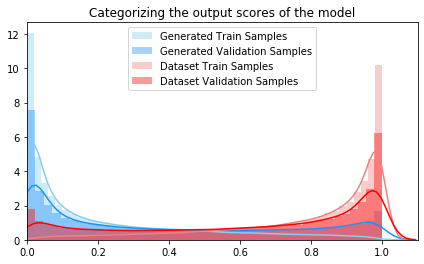

 32%|███▏      | 300031/946094 [40:14<10:28:08, 17.14it/s]

Training Accuracy at epoch 18: 84.62866666666666
Validation Accuracy epoch 18: 65.17733333333334


 37%|███▋      | 349995/946094 [46:54<1:23:15, 119.33it/s]

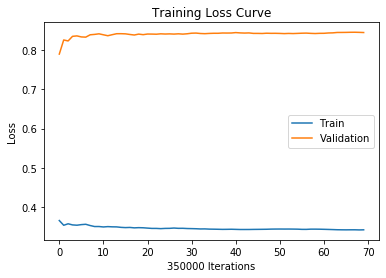

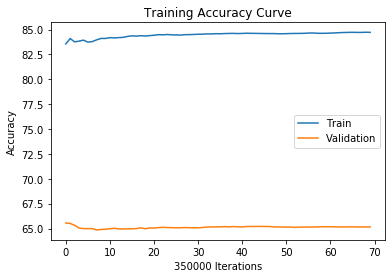

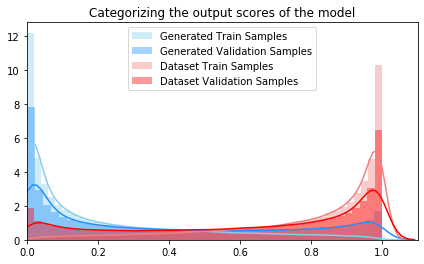

 37%|███▋      | 350031/946094 [46:58<9:10:21, 18.05it/s] 

Training Accuracy at epoch 18: 84.722
Validation Accuracy epoch 18: 65.16085714285714


 42%|████▏     | 399989/946094 [53:37<55:34, 163.76it/s]  

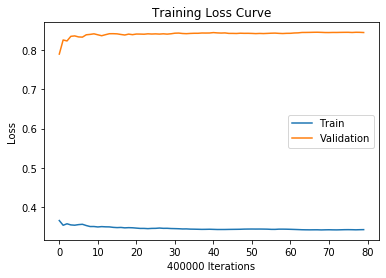

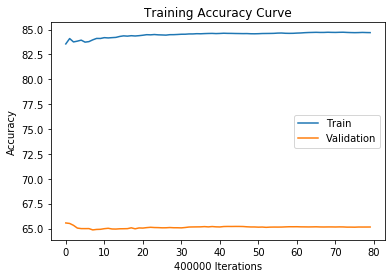

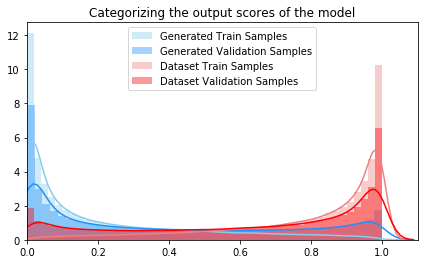

 42%|████▏     | 400027/946094 [53:43<10:16:57, 14.75it/s]

Training Accuracy at epoch 18: 84.69675
Validation Accuracy epoch 18: 65.15225


 48%|████▊     | 449996/946094 [1:00:22<56:34, 146.15it/s]  

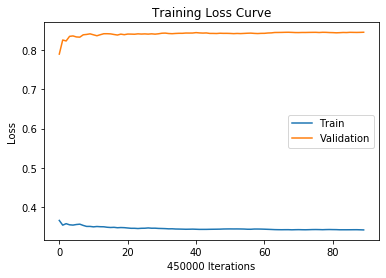

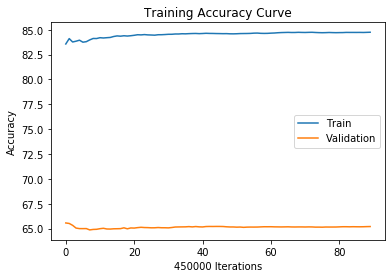

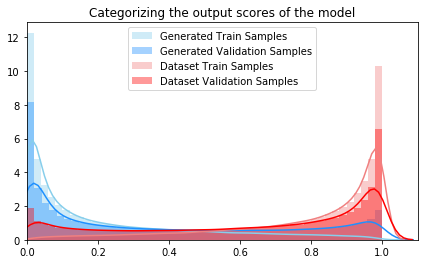

 48%|████▊     | 450032/946094 [1:00:27<8:03:43, 17.09it/s] 

Training Accuracy at epoch 18: 84.74022222222223
Validation Accuracy epoch 18: 65.19911111111111


 53%|█████▎    | 499997/946094 [1:07:08<1:15:03, 99.06it/s] 

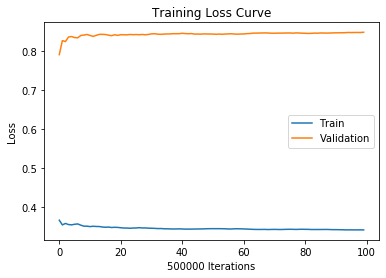

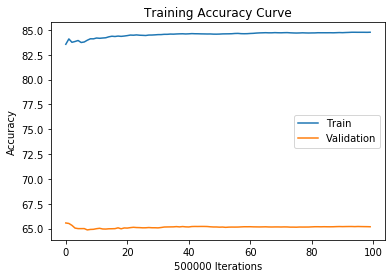

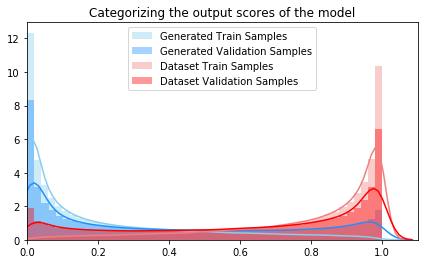

 53%|█████▎    | 500031/946094 [1:07:14<10:55:29, 11.34it/s]

Training Accuracy at epoch 18: 84.773
Validation Accuracy epoch 18: 65.1786


 58%|█████▊    | 549996/946094 [1:13:52<41:40, 158.40it/s]  

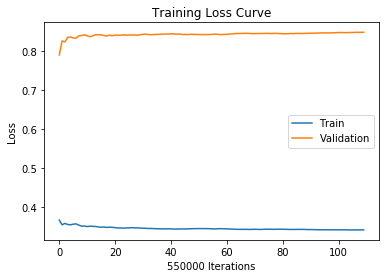

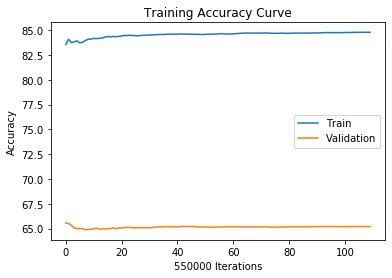

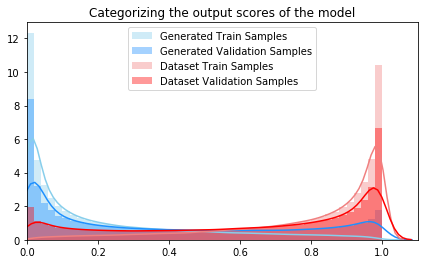

 58%|█████▊    | 550014/946094 [1:13:58<9:59:08, 11.02it/s]

Training Accuracy at epoch 18: 84.80127272727273
Validation Accuracy epoch 18: 65.19654545454546


 63%|██████▎   | 599985/946094 [1:20:37<44:22, 129.99it/s]  

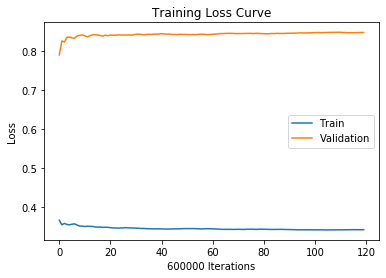

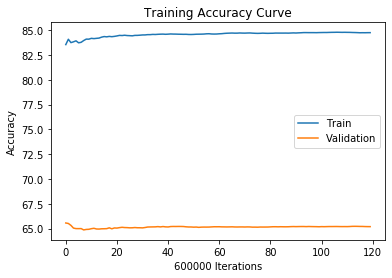

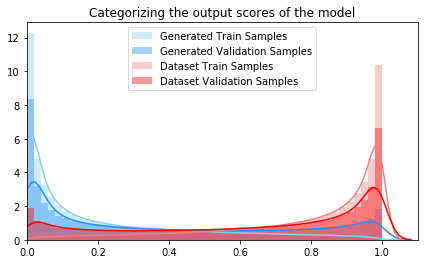

 63%|██████▎   | 600024/946094 [1:20:44<7:51:08, 12.24it/s] 

Training Accuracy at epoch 18: 84.76533333333333
Validation Accuracy epoch 18: 65.1905


 69%|██████▊   | 649991/946094 [1:27:24<54:50, 89.99it/s]  

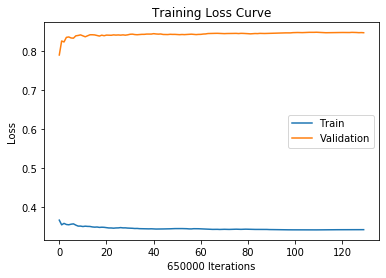

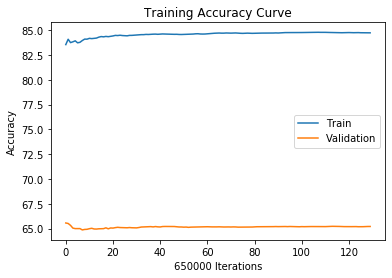

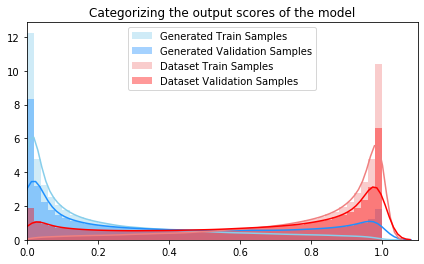

 69%|██████▊   | 650023/946094 [1:27:30<7:28:57, 10.99it/s] 

Training Accuracy at epoch 18: 84.74738461538462
Validation Accuracy epoch 18: 65.20753846153846


 74%|███████▍  | 699987/946094 [1:34:12<27:39, 148.34it/s] 

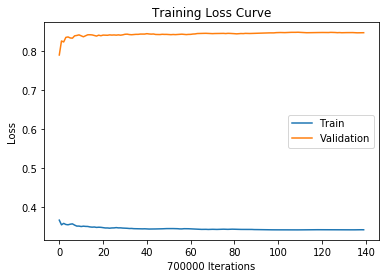

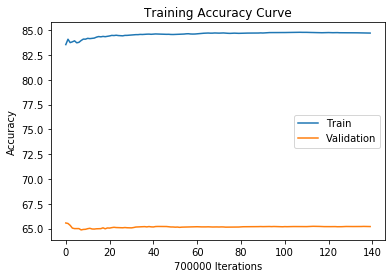

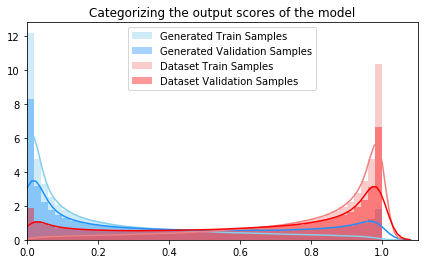

 74%|███████▍  | 700021/946094 [1:34:20<6:09:11, 11.11it/s]

Training Accuracy at epoch 18: 84.723
Validation Accuracy epoch 18: 65.19914285714286


 79%|███████▉  | 749985/946094 [1:41:00<30:38, 106.69it/s] 

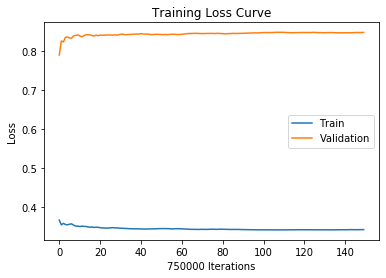

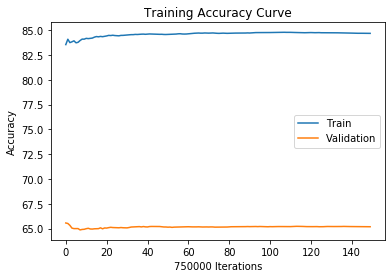

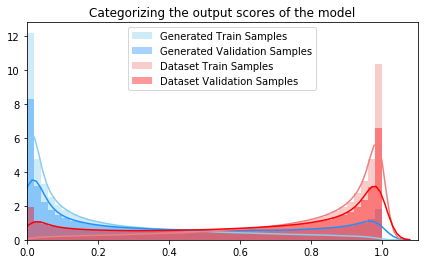

 79%|███████▉  | 750019/946094 [1:41:07<4:53:27, 11.14it/s]

Training Accuracy at epoch 18: 84.69426666666666
Validation Accuracy epoch 18: 65.18053333333333


 85%|████████▍ | 799987/946094 [1:47:48<15:21, 158.58it/s] 

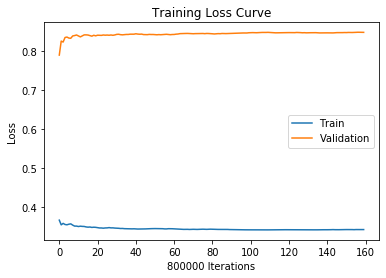

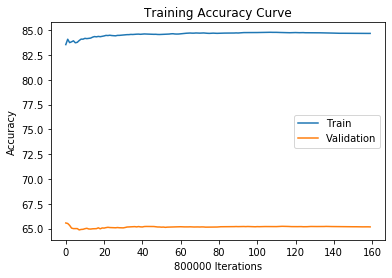

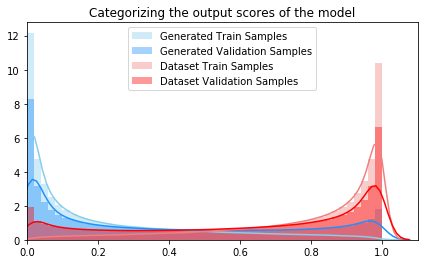

 85%|████████▍ | 800023/946094 [1:47:56<3:59:27, 10.17it/s]

Training Accuracy at epoch 18: 84.689875
Validation Accuracy epoch 18: 65.165375


 90%|████████▉ | 849994/946094 [1:54:37<11:40, 137.11it/s] 

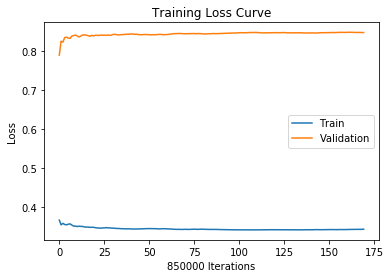

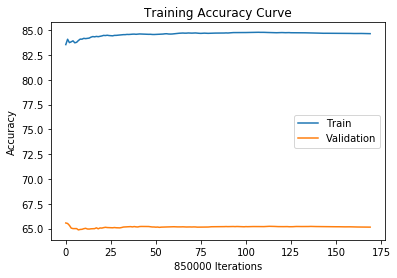

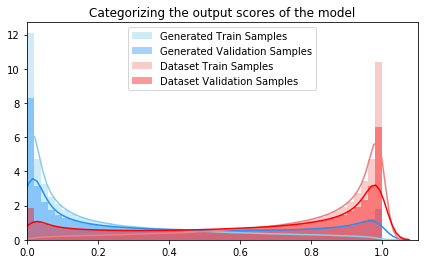

 90%|████████▉ | 850028/946094 [1:54:44<2:25:16, 11.02it/s]

Training Accuracy at epoch 18: 84.66458823529412
Validation Accuracy epoch 18: 65.14082352941176


 95%|█████████▌| 899998/946094 [2:01:29<07:12, 106.69it/s] 

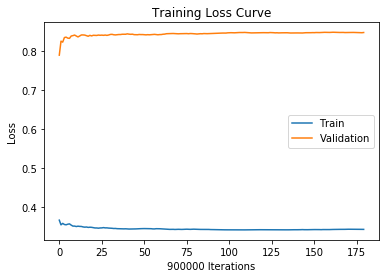

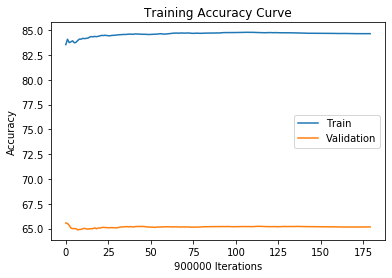

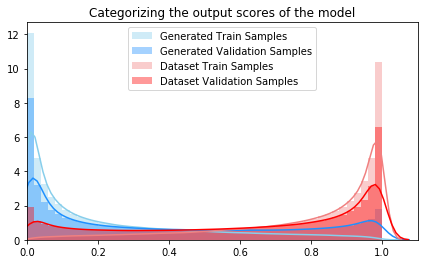

 95%|█████████▌| 900035/946094 [2:01:37<1:26:34,  8.87it/s]

Training Accuracy at epoch 18: 84.66266666666667
Validation Accuracy epoch 18: 65.1601111111111


  0%|          | 15/946094 [00:00<1:46:52, 147.54it/s]

Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/06172020.pth
Starting epoch: 19  with learning rate:  [0.1]


  0%|          | 3905/946094 [00:30<1:39:29, 157.84it/s]

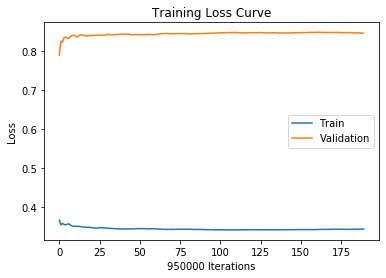

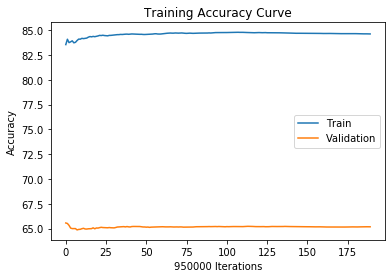

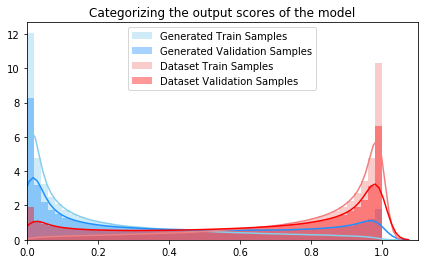

Training Accuracy at epoch 19: 84.636
Validation Accuracy epoch 19: 65.17452631578948


  6%|▌         | 53905/946094 [07:19<1:49:18, 136.05it/s]

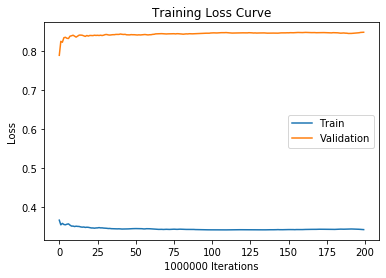

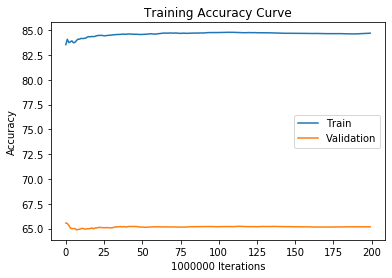

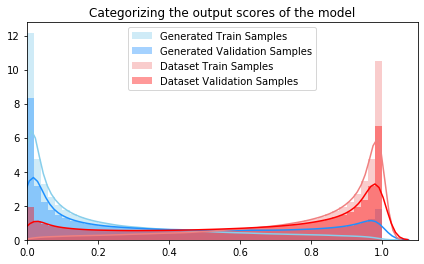

  6%|▌         | 53941/946094 [07:28<26:39:57,  9.29it/s]

Training Accuracy at epoch 19: 84.7129
Validation Accuracy epoch 19: 65.1738


 11%|█         | 103898/946094 [14:12<2:54:46, 80.31it/s] 

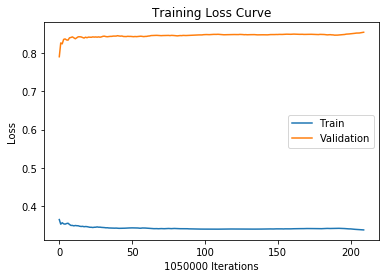

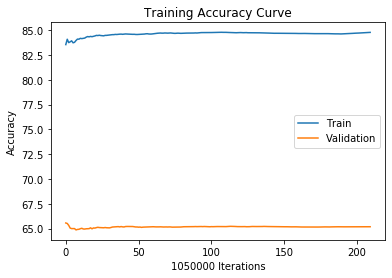

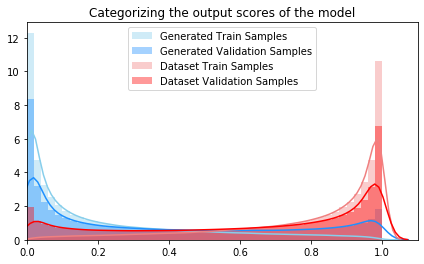

 11%|█         | 103932/946094 [14:21<31:06:04,  7.52it/s]

Training Accuracy at epoch 19: 84.79257142857143
Validation Accuracy epoch 19: 65.18038095238096


 16%|█▋        | 153898/946094 [21:24<1:28:37, 148.97it/s]

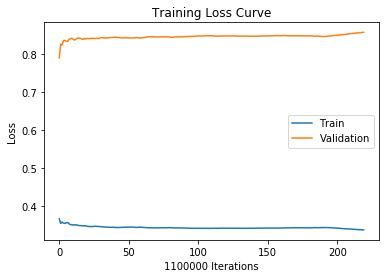

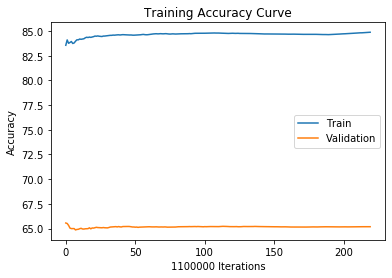

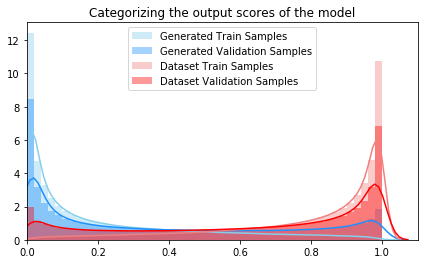

 16%|█▋        | 153935/946094 [21:33<25:00:07,  8.80it/s]

Training Accuracy at epoch 19: 84.87772727272727
Validation Accuracy epoch 19: 65.18427272727273


 22%|██▏       | 203889/946094 [28:14<1:55:30, 107.09it/s]

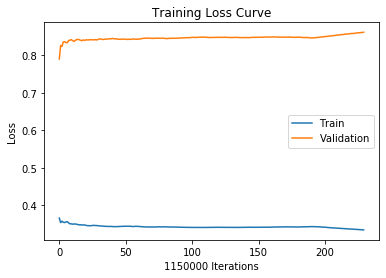

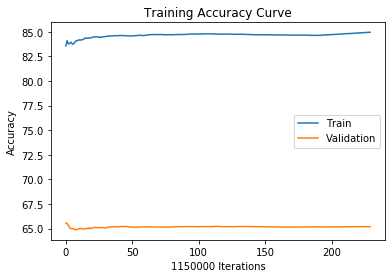

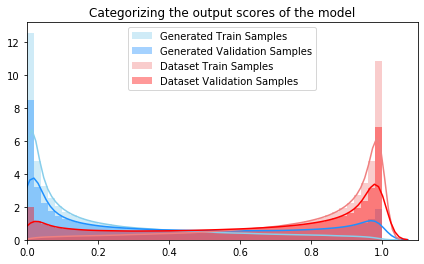

 22%|██▏       | 203927/946094 [28:23<24:04:42,  8.56it/s]

Training Accuracy at epoch 19: 84.95834782608695
Validation Accuracy epoch 19: 65.19391304347826


 27%|██▋       | 253887/946094 [35:03<1:14:13, 155.45it/s]

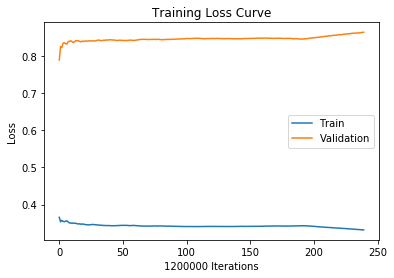

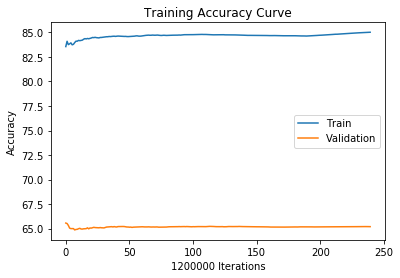

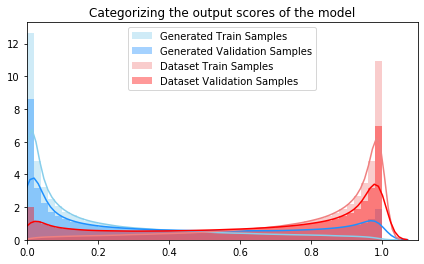

 27%|██▋       | 253924/946094 [35:13<22:48:54,  8.43it/s]

Training Accuracy at epoch 19: 85.02283333333334
Validation Accuracy epoch 19: 65.19266666666667


 32%|███▏      | 303900/946094 [41:53<1:18:08, 136.97it/s]

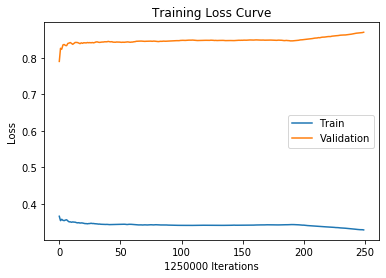

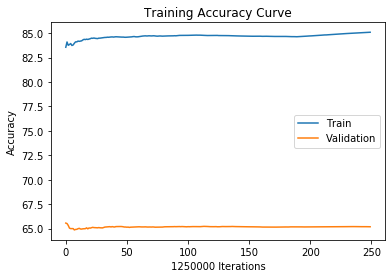

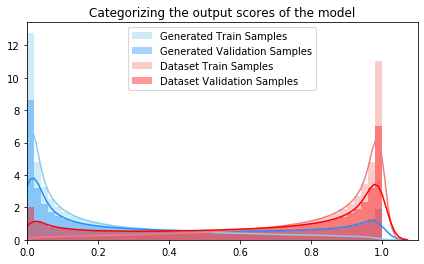

 32%|███▏      | 303937/946094 [42:03<21:39:24,  8.24it/s]

Training Accuracy at epoch 19: 85.09552
Validation Accuracy epoch 19: 65.18352


 37%|███▋      | 353898/946094 [48:47<1:35:22, 103.49it/s]

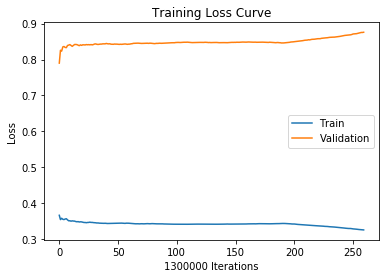

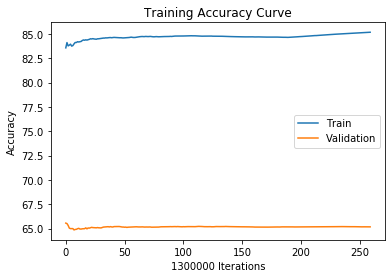

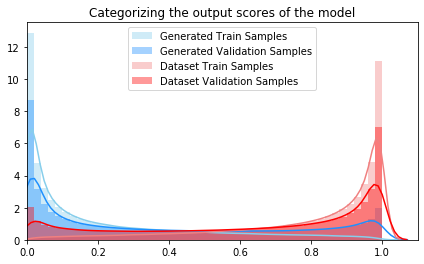

 37%|███▋      | 353931/946094 [48:58<23:46:24,  6.92it/s]

Training Accuracy at epoch 19: 85.16338461538462
Validation Accuracy epoch 19: 65.17430769230769


 43%|████▎     | 403893/946094 [55:39<57:59, 155.84it/s]  

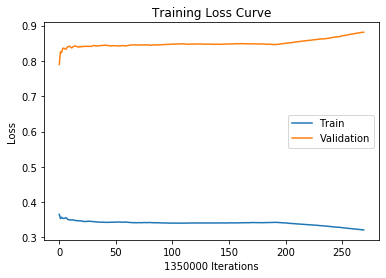

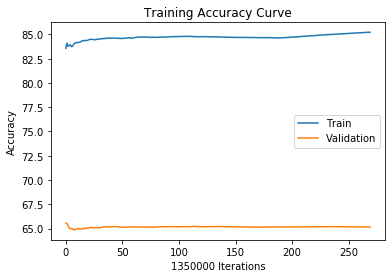

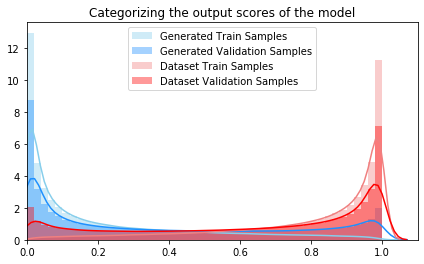

 43%|████▎     | 403911/946094 [55:49<25:26:22,  5.92it/s]

Training Accuracy at epoch 19: 85.22318518518519
Validation Accuracy epoch 19: 65.17022222222222


 48%|████▊     | 453891/946094 [1:02:31<1:08:27, 119.84it/s]

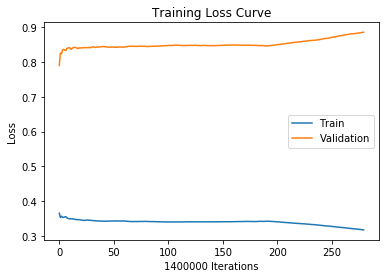

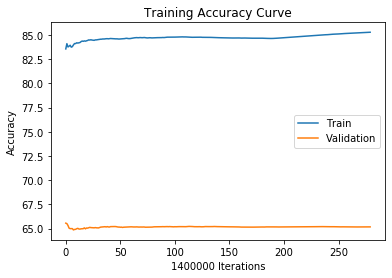

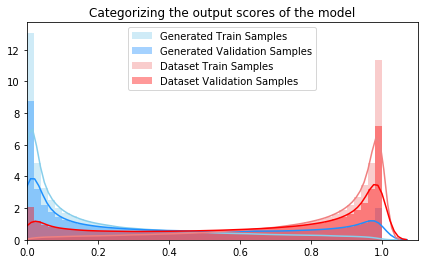

 48%|████▊     | 453924/946094 [1:02:43<20:23:34,  6.70it/s]

Training Accuracy at epoch 19: 85.28114285714285
Validation Accuracy epoch 19: 65.173


 53%|█████▎    | 503901/946094 [1:09:21<1:21:27, 90.48it/s] 

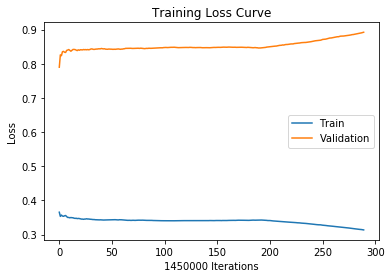

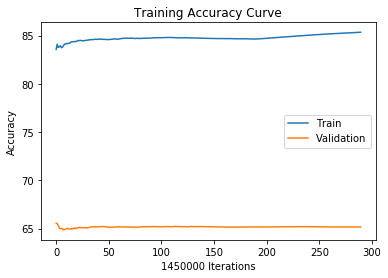

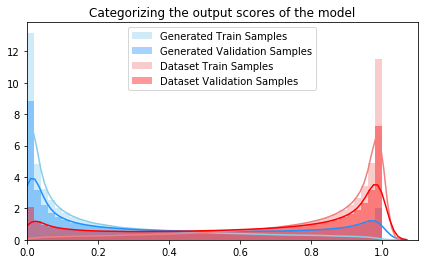

 53%|█████▎    | 503935/946094 [1:09:32<19:33:19,  6.28it/s]

Training Accuracy at epoch 19: 85.34131034482759
Validation Accuracy epoch 19: 65.1691724137931


 59%|█████▊    | 553900/946094 [1:16:10<45:35, 143.38it/s]  

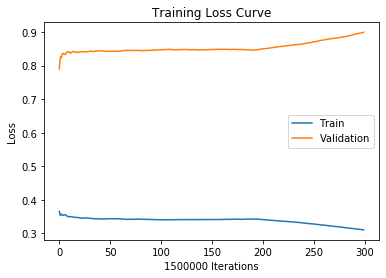

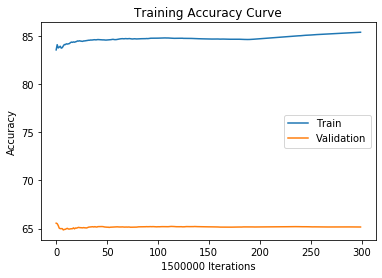

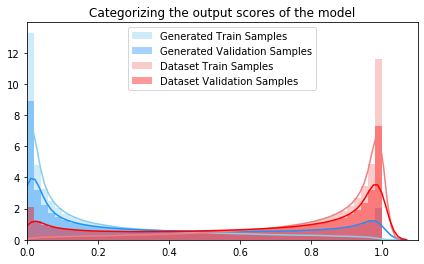

 59%|█████▊    | 553935/946094 [1:16:23<16:50:35,  6.47it/s]

Training Accuracy at epoch 19: 85.39266666666667
Validation Accuracy epoch 19: 65.1628


 64%|██████▍   | 603888/946094 [1:23:01<58:38, 97.27it/s]   

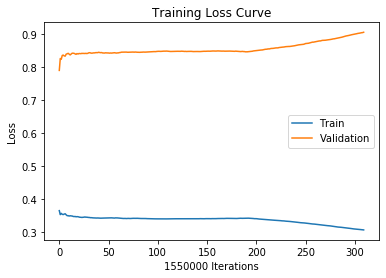

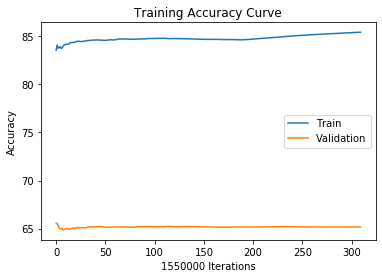

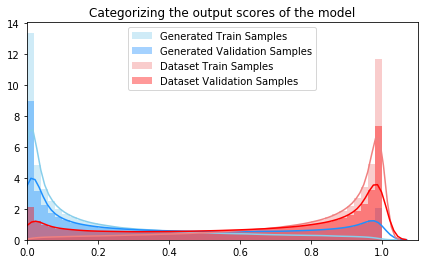

 64%|██████▍   | 603924/946094 [1:23:13<13:30:35,  7.04it/s]

Training Accuracy at epoch 19: 85.4274193548387
Validation Accuracy epoch 19: 65.16606451612903


 69%|██████▉   | 653903/946094 [1:30:01<31:06, 156.58it/s]  

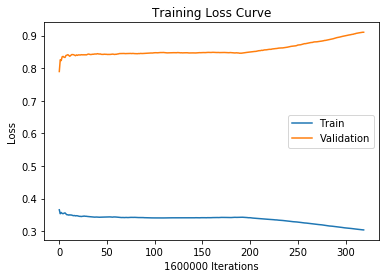

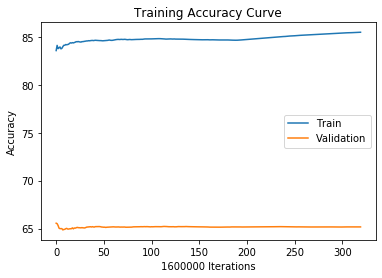

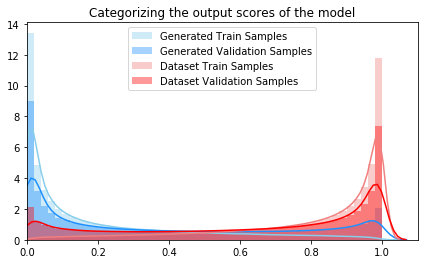

 69%|██████▉   | 653938/946094 [1:30:14<13:18:54,  6.09it/s]

Training Accuracy at epoch 19: 85.4709375
Validation Accuracy epoch 19: 65.1725


 74%|███████▍  | 703899/946094 [1:37:02<31:09, 129.52it/s]  

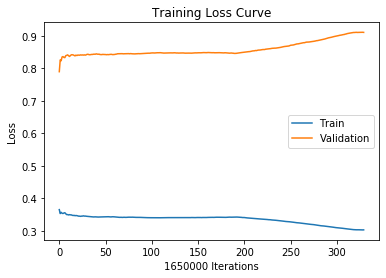

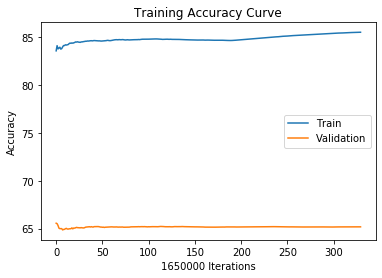

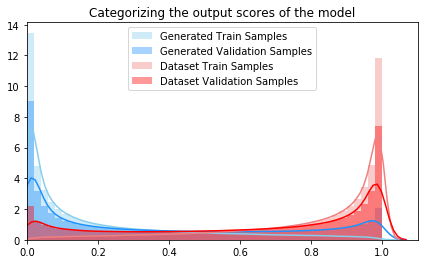

 74%|███████▍  | 703934/946094 [1:37:15<10:28:30,  6.42it/s]

Training Accuracy at epoch 19: 85.5010303030303
Validation Accuracy epoch 19: 65.18060606060607


 80%|███████▉  | 753887/946094 [1:44:02<36:39, 87.39it/s]   

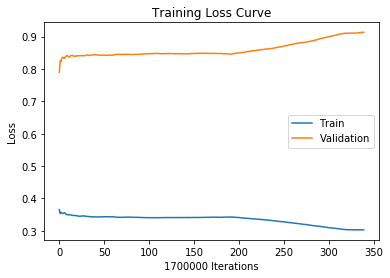

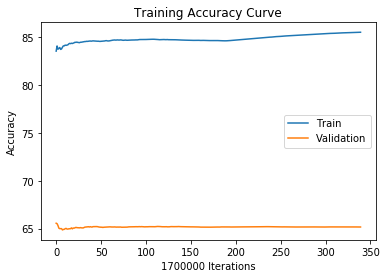

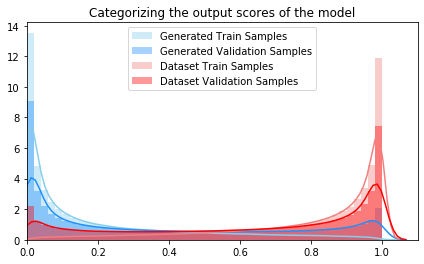

 80%|███████▉  | 753924/946094 [1:44:16<8:28:34,  6.30it/s] 

Training Accuracy at epoch 19: 85.53570588235294
Validation Accuracy epoch 19: 65.16447058823529


 85%|████████▍ | 803904/946094 [1:50:57<15:02, 157.51it/s] 

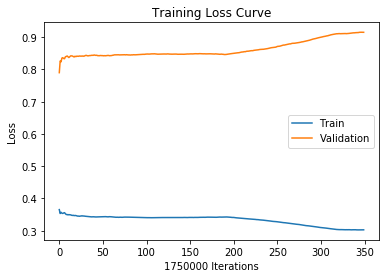

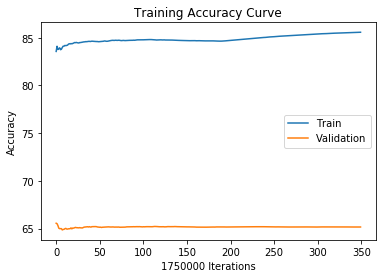

 85%|████████▍ | 803904/946094 [1:51:10<15:02, 157.51it/s]

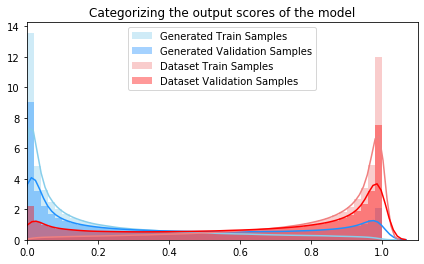

 85%|████████▍ | 803906/946094 [1:51:10<75:30:54,  1.91s/it]

Training Accuracy at epoch 19: 85.56977142857143
Validation Accuracy epoch 19: 65.1656


 90%|█████████ | 853904/946094 [1:57:56<13:00, 118.09it/s]  

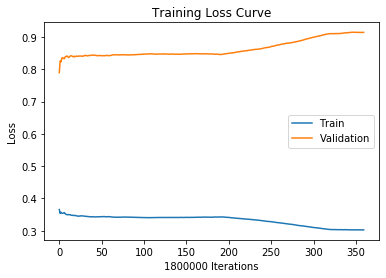

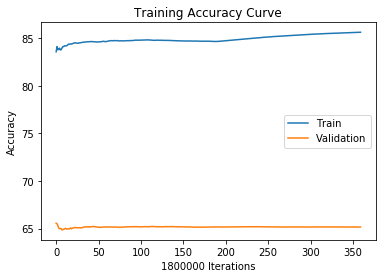

 90%|█████████ | 853904/946094 [1:58:10<13:00, 118.09it/s]

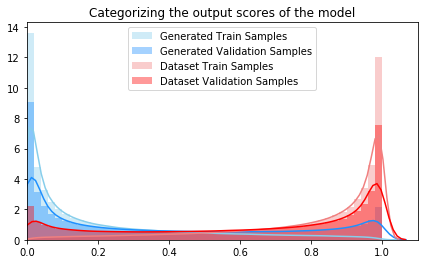

 90%|█████████ | 853920/946094 [1:58:10<37:36:51,  1.47s/it]

Training Accuracy at epoch 19: 85.60655555555556
Validation Accuracy epoch 19: 65.16366666666667


 96%|█████████▌| 903892/946094 [2:04:48<07:51, 89.47it/s]   

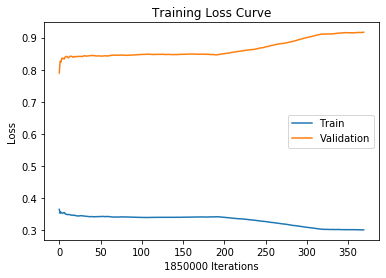

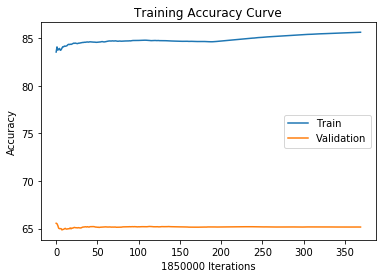

 96%|█████████▌| 903892/946094 [2:05:00<07:51, 89.47it/s]

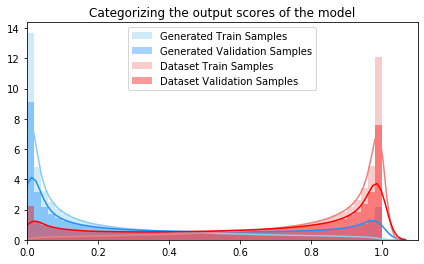

 96%|█████████▌| 903924/946094 [2:05:02<2:29:38,  4.70it/s]

Training Accuracy at epoch 19: 85.63956756756757
Validation Accuracy epoch 19: 65.1618918918919


  0%|          | 19/946094 [00:00<1:26:02, 183.24it/s]

Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/06172020.pth
Starting epoch: 20  with learning rate:  [0.1]


  1%|          | 7805/946094 [01:02<1:46:34, 146.73it/s]

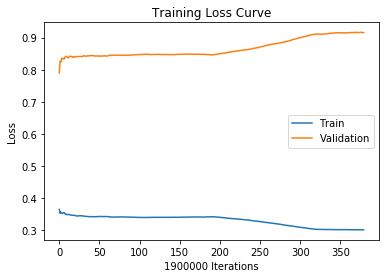

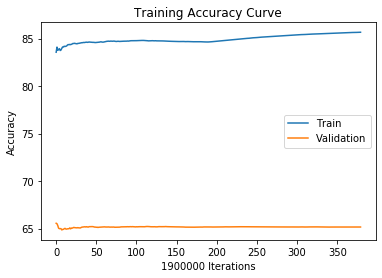

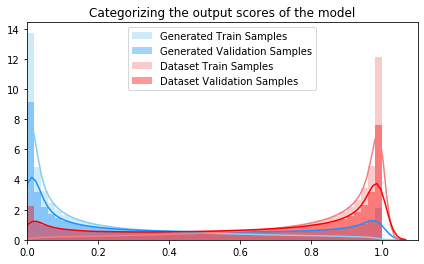

  1%|          | 7841/946094 [01:17<45:40:08,  5.71it/s]

Training Accuracy at epoch 20: 85.66394736842105
Validation Accuracy epoch 20: 65.1651052631579


  6%|▌         | 57799/946094 [07:59<2:25:25, 101.80it/s]

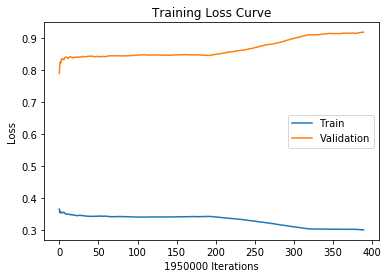

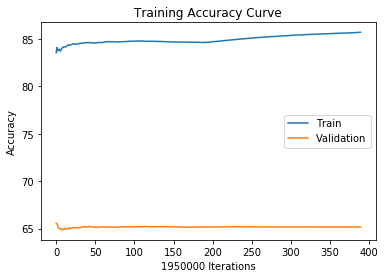

  6%|▌         | 57799/946094 [08:10<2:25:25, 101.80it/s]

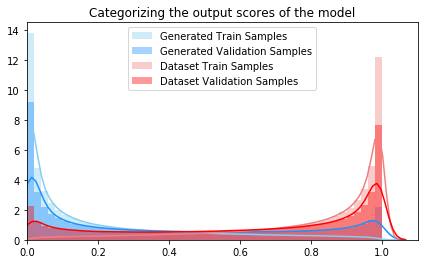

  6%|▌         | 57830/946094 [08:13<58:54:20,  4.19it/s]

Training Accuracy at epoch 20: 85.71994871794872
Validation Accuracy epoch 20: 65.16328205128205


 11%|█▏        | 107809/946094 [14:54<1:24:32, 165.25it/s]

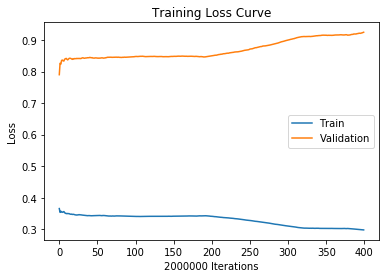

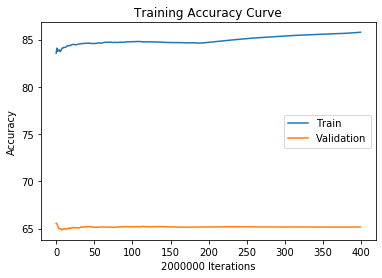

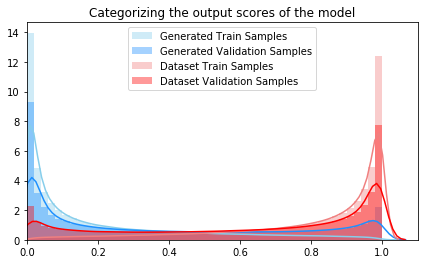

 11%|█▏        | 107846/946094 [15:09<40:54:09,  5.69it/s]

Training Accuracy at epoch 20: 85.7815
Validation Accuracy epoch 20: 65.1651


 17%|█▋        | 157805/946094 [21:53<1:34:02, 139.71it/s]

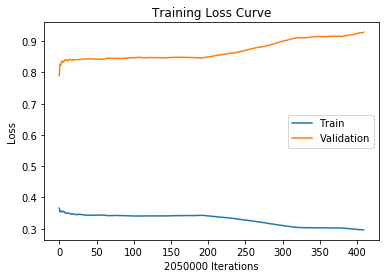

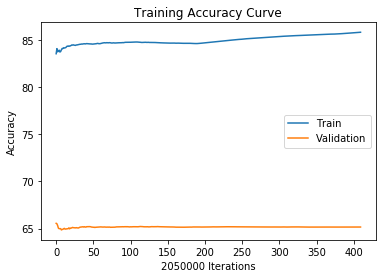

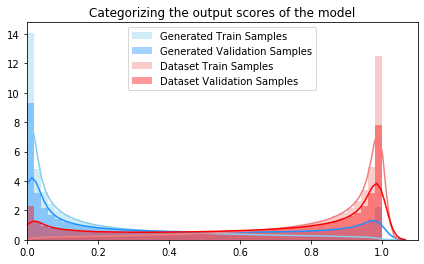

 17%|█▋        | 157840/946094 [22:08<41:16:50,  5.30it/s]

Training Accuracy at epoch 20: 85.83980487804878
Validation Accuracy epoch 20: 65.16619512195122


 22%|██▏       | 207811/946094 [28:47<1:59:00, 103.40it/s]

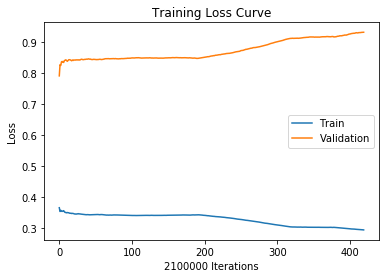

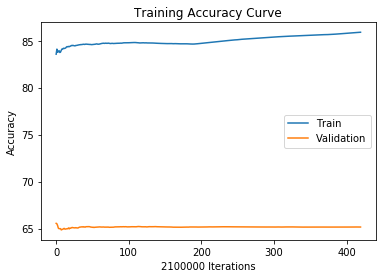

 22%|██▏       | 207811/946094 [29:00<1:59:00, 103.40it/s]

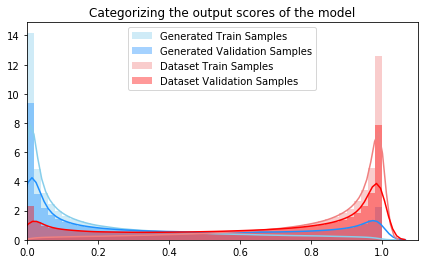

 22%|██▏       | 207830/946094 [29:03<695:24:02,  3.39s/it]

Training Accuracy at epoch 20: 85.896
Validation Accuracy epoch 20: 65.16690476190476


 27%|██▋       | 257794/946094 [35:42<1:16:28, 150.01it/s] 

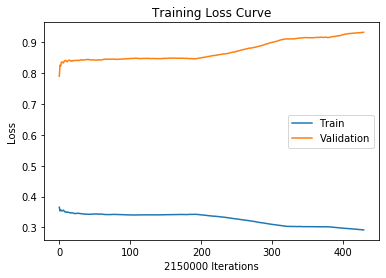

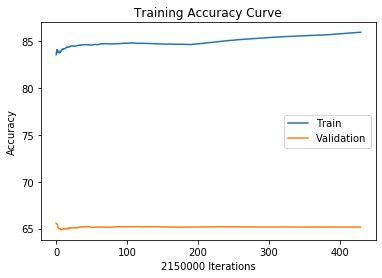

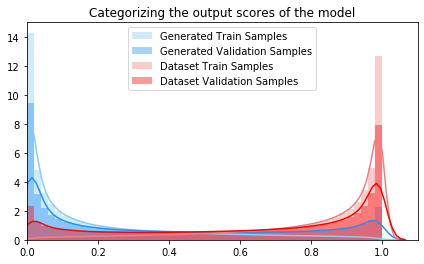

 27%|██▋       | 257812/946094 [35:58<50:57:50,  3.75it/s]

Training Accuracy at epoch 20: 85.94944186046511
Validation Accuracy epoch 20: 65.17227906976744


 33%|███▎      | 307810/946094 [42:35<1:19:10, 134.37it/s]

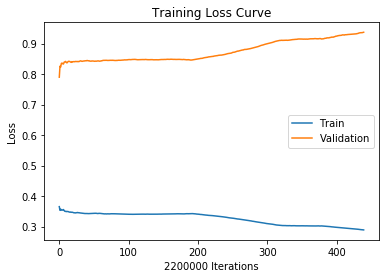

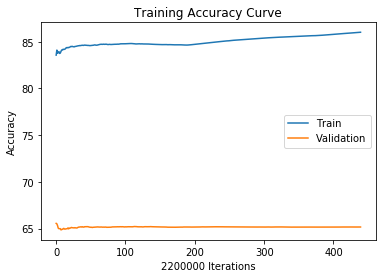

 33%|███▎      | 307810/946094 [42:50<1:19:10, 134.37it/s]

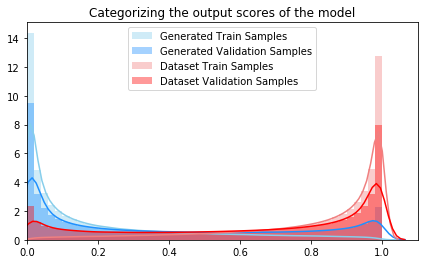

 33%|███▎      | 307825/946094 [42:52<317:44:32,  1.79s/it]

Training Accuracy at epoch 20: 86.00990909090909
Validation Accuracy epoch 20: 65.17027272727273


 38%|███▊      | 357800/946094 [49:29<1:49:29, 89.54it/s]  

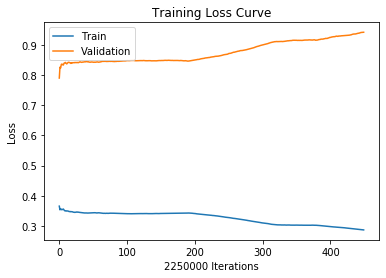

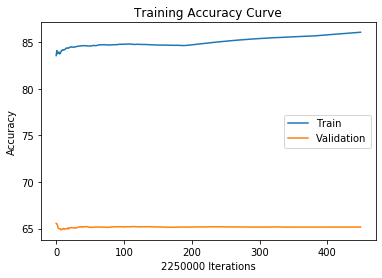

 38%|███▊      | 357800/946094 [49:40<1:49:29, 89.54it/s]

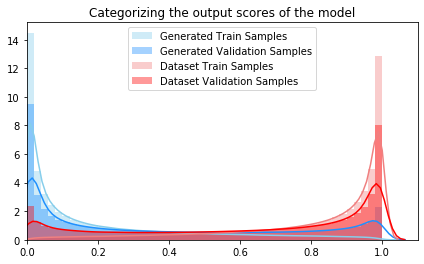

 38%|███▊      | 357829/946094 [49:46<46:56:44,  3.48it/s]

Training Accuracy at epoch 20: 86.06515555555555
Validation Accuracy epoch 20: 65.16853333333333


 43%|████▎     | 407800/946094 [56:21<1:01:39, 145.52it/s]

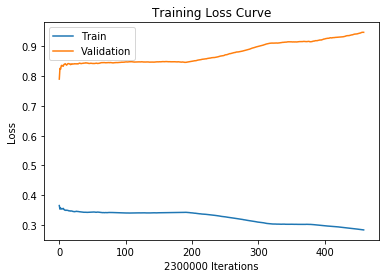

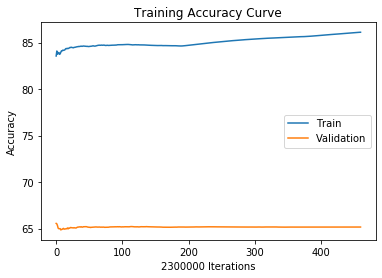

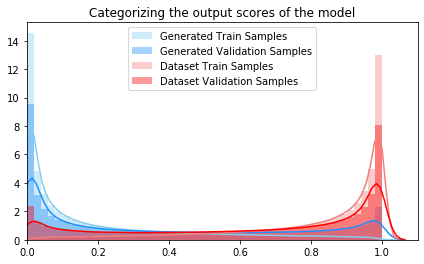

 43%|████▎     | 407834/946094 [56:39<32:22:52,  4.62it/s]

Training Accuracy at epoch 20: 86.11595652173914
Validation Accuracy epoch 20: 65.16943478260869


 48%|████▊     | 457802/946094 [1:03:16<1:06:59, 121.48it/s]

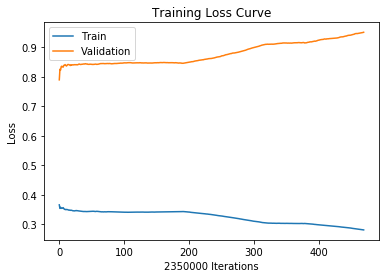

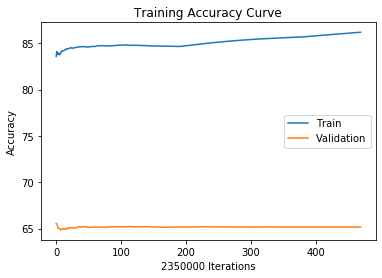

 48%|████▊     | 457802/946094 [1:03:30<1:06:59, 121.48it/s]

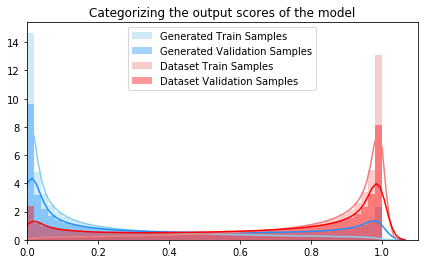

 48%|████▊     | 457847/946094 [1:03:34<35:07:23,  3.86it/s]

Training Accuracy at epoch 20: 86.17370212765958
Validation Accuracy epoch 20: 65.16655319148936


 54%|█████▎    | 507806/946094 [1:10:10<43:54, 166.36it/s]  

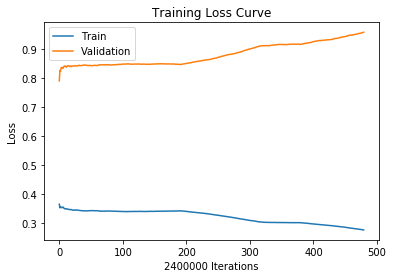

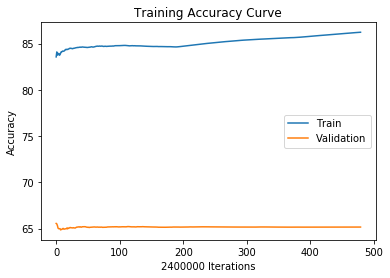

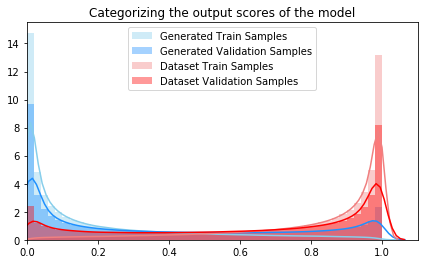

 54%|█████▎    | 507841/946094 [1:10:29<25:52:52,  4.70it/s]

Training Accuracy at epoch 20: 86.226375
Validation Accuracy epoch 20: 65.16875


 59%|█████▉    | 557796/946094 [1:17:07<47:13, 137.04it/s]  

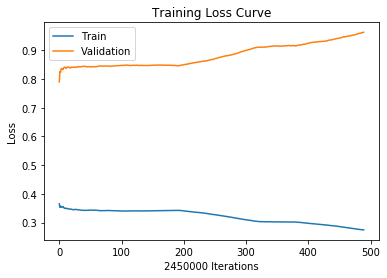

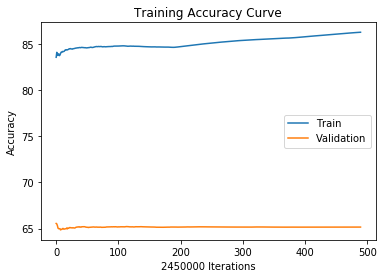

 59%|█████▉    | 557796/946094 [1:17:20<47:13, 137.04it/s]

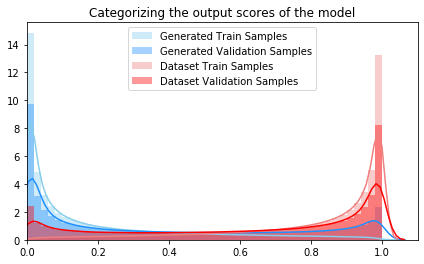

 59%|█████▉    | 557830/946094 [1:17:25<24:57:31,  4.32it/s]

Training Accuracy at epoch 20: 86.27436734693877
Validation Accuracy epoch 20: 65.1669387755102


 64%|██████▍   | 607806/946094 [1:24:03<52:28, 107.44it/s]  

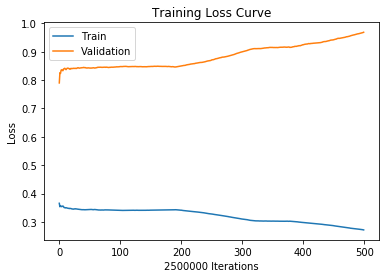

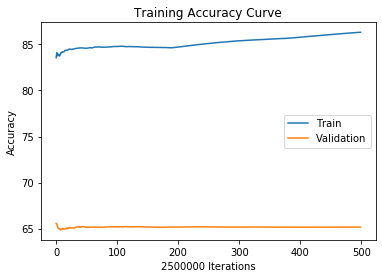

 64%|██████▍   | 607806/946094 [1:24:20<52:28, 107.44it/s]

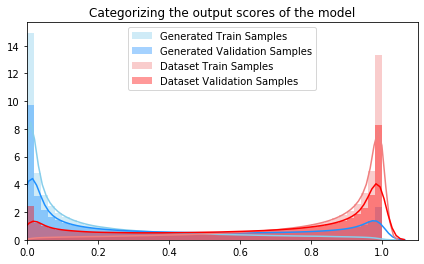

 64%|██████▍   | 607829/946094 [1:24:22<63:14:46,  1.49it/s]

Training Accuracy at epoch 20: 86.32388
Validation Accuracy epoch 20: 65.16432


 70%|██████▉   | 657807/946094 [1:30:59<30:16, 158.67it/s]  

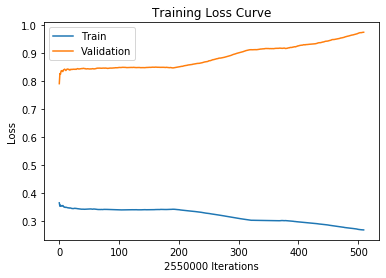

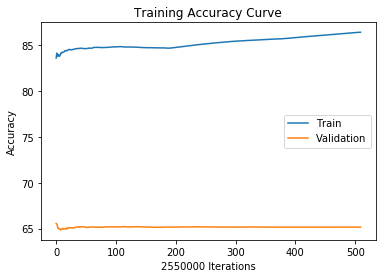

 70%|██████▉   | 657807/946094 [1:31:10<30:16, 158.67it/s]

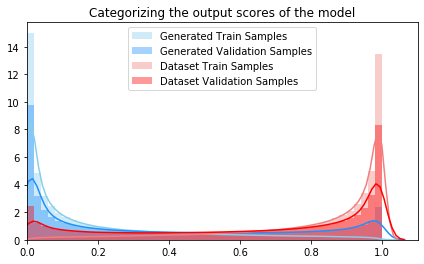

 70%|██████▉   | 657812/946094 [1:31:17<86:53:24,  1.09s/it]

Training Accuracy at epoch 20: 86.36929411764706
Validation Accuracy epoch 20: 65.16341176470588


 75%|███████▍  | 707805/946094 [1:37:52<32:15, 123.09it/s]  

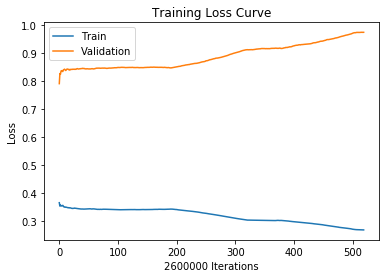

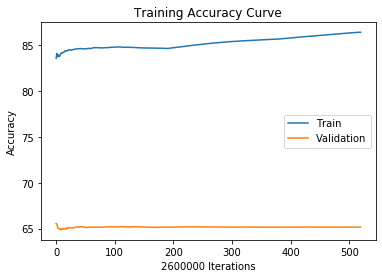

 75%|███████▍  | 707805/946094 [1:38:10<32:15, 123.09it/s]

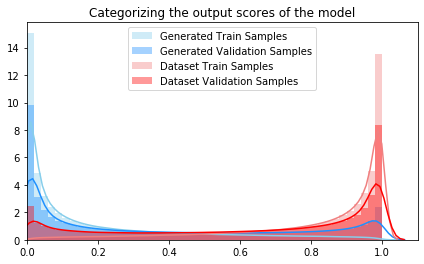

 75%|███████▍  | 707830/946094 [1:38:12<38:35:39,  1.71it/s]

Training Accuracy at epoch 20: 86.40511538461539
Validation Accuracy epoch 20: 65.16326923076923


 80%|████████  | 757810/946094 [1:44:47<34:27, 91.08it/s]   

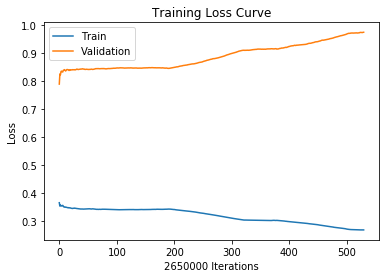

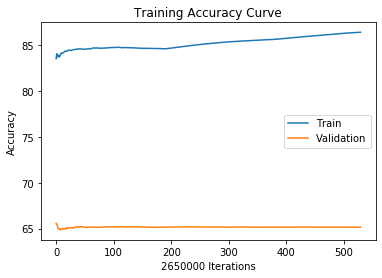

 80%|████████  | 757810/946094 [1:45:00<34:27, 91.08it/s]

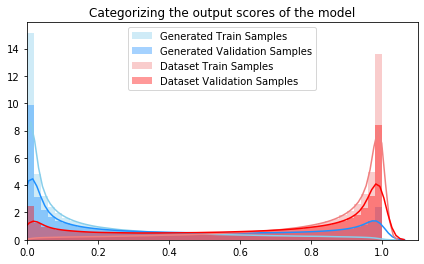

 80%|████████  | 757830/946094 [1:45:06<106:51:15,  2.04s/it]

Training Accuracy at epoch 20: 86.44524528301886
Validation Accuracy epoch 20: 65.15566037735849


 85%|████████▌ | 807800/946094 [1:51:43<15:27, 149.11it/s]   

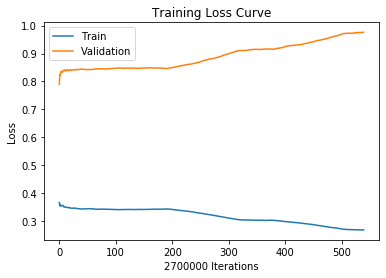

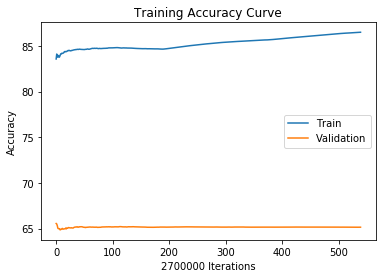

 85%|████████▌ | 807800/946094 [1:52:00<15:27, 149.11it/s]

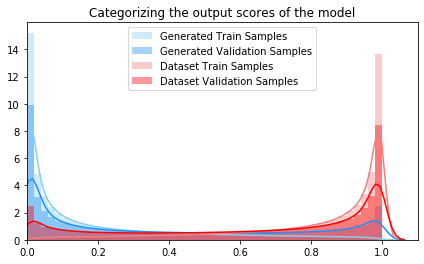

 85%|████████▌ | 807830/946094 [1:52:03<13:31:09,  2.84it/s]

Training Accuracy at epoch 20: 86.48429629629629
Validation Accuracy epoch 20: 65.15666666666667


 91%|█████████ | 857796/946094 [1:58:40<13:51, 106.23it/s]  

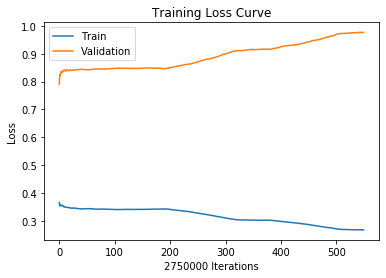

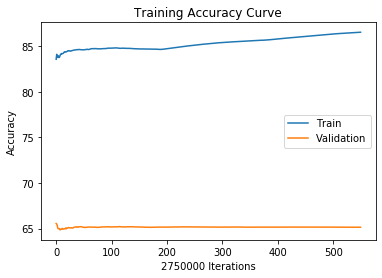

 91%|█████████ | 857796/946094 [1:58:50<13:51, 106.23it/s]

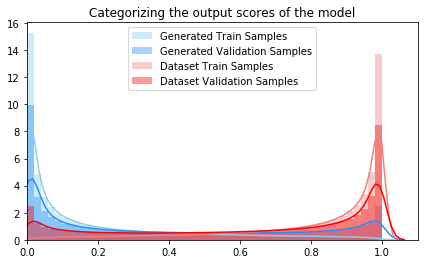

 91%|█████████ | 857829/946094 [1:58:59<6:22:27,  3.85it/s]

Training Accuracy at epoch 20: 86.51916363636364
Validation Accuracy epoch 20: 65.1542909090909


 96%|█████████▌| 907793/946094 [2:05:37<04:01, 158.40it/s] 

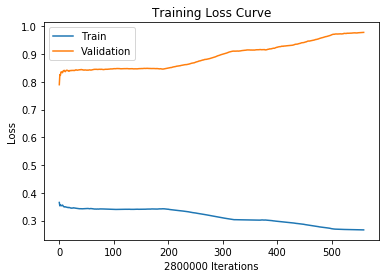

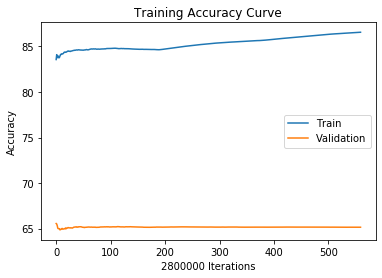

 96%|█████████▌| 907793/946094 [2:05:50<04:01, 158.40it/s]

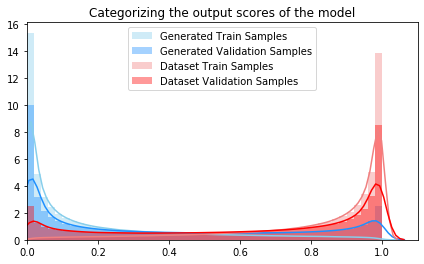

 96%|█████████▌| 907830/946094 [2:05:58<2:30:05,  4.25it/s]

Training Accuracy at epoch 20: 86.55828571428572
Validation Accuracy epoch 20: 65.15517857142858


  0%|          | 19/946094 [00:00<1:24:18, 187.04it/s]

Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/06172020.pth
Starting epoch: 21  with learning rate:  [0.08100000000000002]


  1%|          | 11704/946094 [01:33<1:53:23, 137.34it/s]

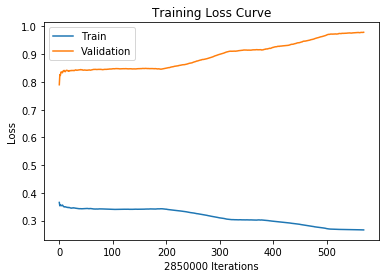

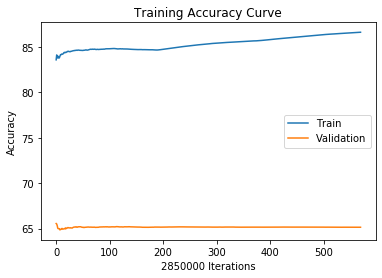

  1%|          | 11704/946094 [01:50<1:53:23, 137.34it/s]

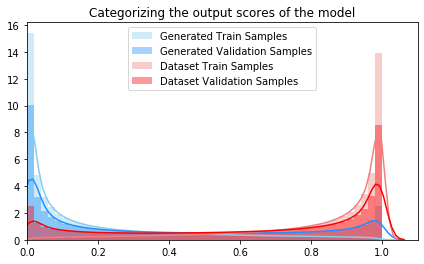

  1%|          | 11736/946094 [01:53<79:21:51,  3.27it/s] 

Training Accuracy at epoch 21: 86.59252631578947
Validation Accuracy epoch 21: 65.1538947368421


  7%|▋         | 61708/946094 [08:30<2:22:16, 103.61it/s]

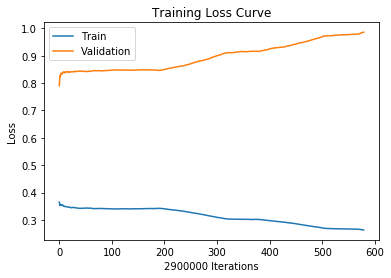

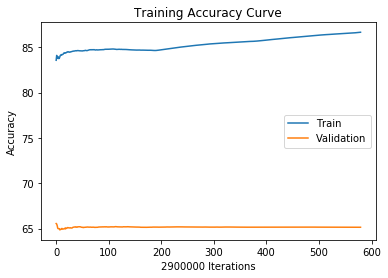

  7%|▋         | 61708/946094 [08:50<2:22:16, 103.61it/s]

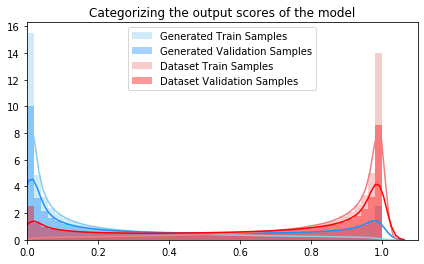

  7%|▋         | 61736/946094 [08:52<114:11:18,  2.15it/s]

Training Accuracy at epoch 21: 86.65106896551724
Validation Accuracy epoch 21: 65.15458620689655


 12%|█▏        | 111707/946094 [15:28<1:27:32, 158.86it/s]

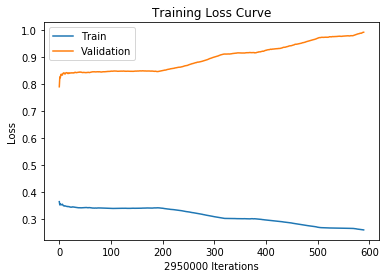

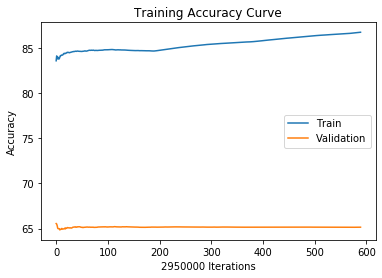

 12%|█▏        | 111707/946094 [15:40<1:27:32, 158.86it/s]

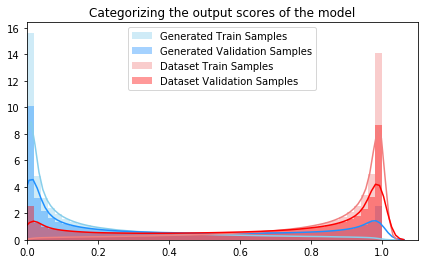

 12%|█▏        | 111718/946094 [15:49<136:18:15,  1.70it/s]

Training Accuracy at epoch 21: 86.71447457627119
Validation Accuracy epoch 21: 65.16050847457628


 17%|█▋        | 161698/946094 [22:25<1:46:15, 123.04it/s] 

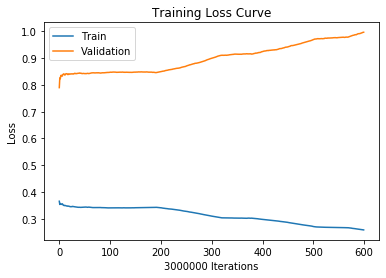

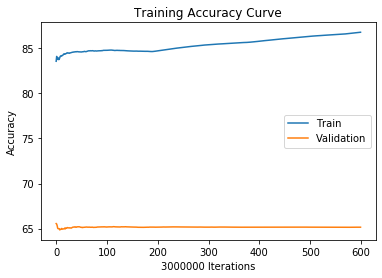

 17%|█▋        | 161698/946094 [22:40<1:46:15, 123.04it/s]

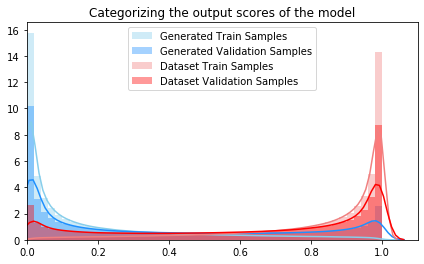

 17%|█▋        | 161736/946094 [22:48<52:30:05,  4.15it/s]

Training Accuracy at epoch 21: 86.7792
Validation Accuracy epoch 21: 65.16056666666667


 22%|██▏       | 211710/946094 [29:24<2:15:11, 90.54it/s] 

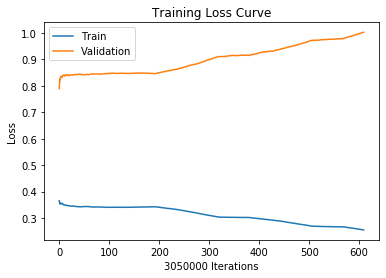

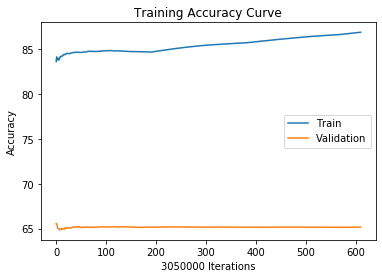

 22%|██▏       | 211710/946094 [29:40<2:15:11, 90.54it/s]

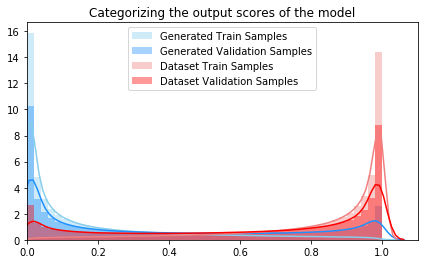

 22%|██▏       | 211736/946094 [29:45<115:09:46,  1.77it/s]

Training Accuracy at epoch 21: 86.84045901639344
Validation Accuracy epoch 21: 65.16524590163934


 28%|██▊       | 261700/946094 [36:21<1:17:24, 147.37it/s] 

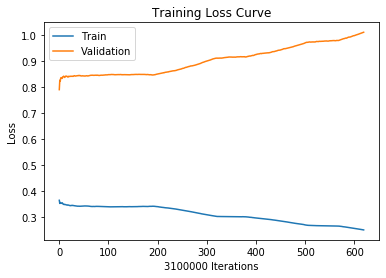

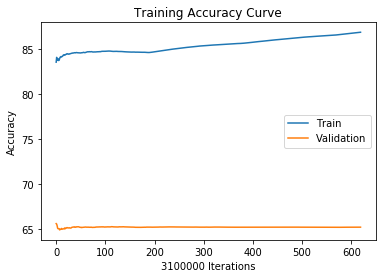

 28%|██▊       | 261700/946094 [36:40<1:17:24, 147.37it/s]

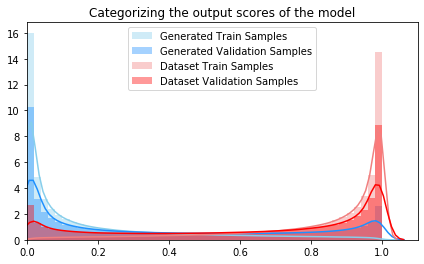

 28%|██▊       | 261736/946094 [36:44<50:58:45,  3.73it/s]

Training Accuracy at epoch 21: 86.89835483870968
Validation Accuracy epoch 21: 65.16593548387097


 33%|███▎      | 311701/946094 [43:18<1:40:03, 105.66it/s]

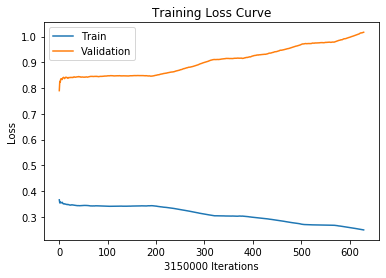

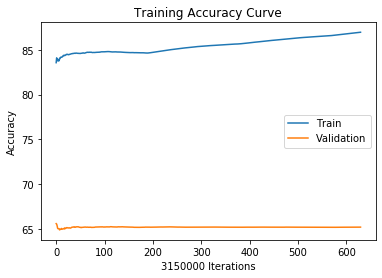

 33%|███▎      | 311701/946094 [43:30<1:40:03, 105.66it/s]

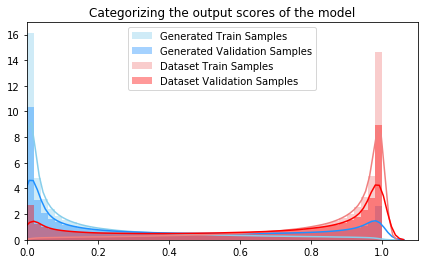

 33%|███▎      | 311735/946094 [43:41<49:10:32,  3.58it/s]

Training Accuracy at epoch 21: 86.96314285714286
Validation Accuracy epoch 21: 65.17136507936507


 38%|███▊      | 361704/946094 [50:19<58:58, 165.14it/s]  

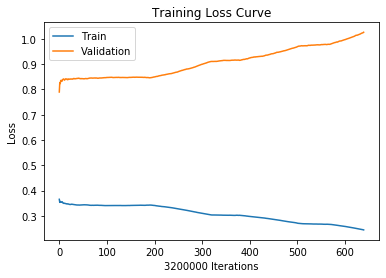

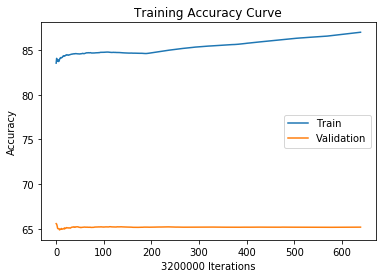

 38%|███▊      | 361704/946094 [50:30<58:58, 165.14it/s]

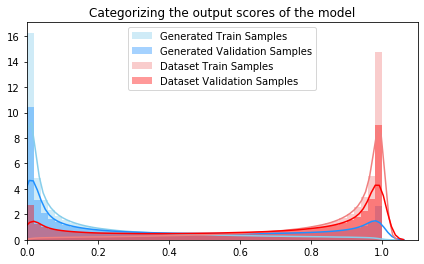

 38%|███▊      | 361735/946094 [50:42<58:34:42,  2.77it/s]

Training Accuracy at epoch 21: 87.0254375
Validation Accuracy epoch 21: 65.169875


 44%|████▎     | 411716/946094 [57:21<1:01:32, 144.71it/s]

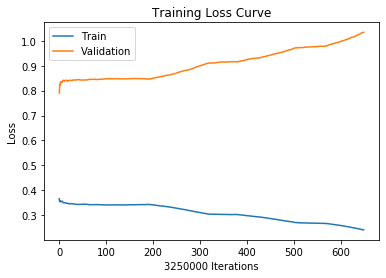

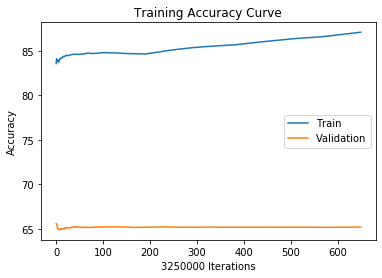

 44%|████▎     | 411716/946094 [57:40<1:01:32, 144.71it/s]

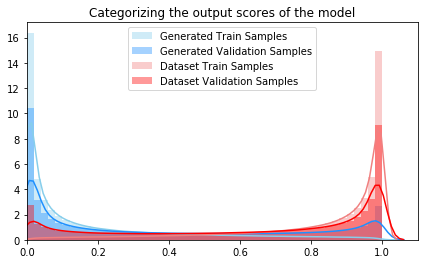

 44%|████▎     | 411736/946094 [57:44<353:41:20,  2.38s/it]

Training Accuracy at epoch 21: 87.08676923076924
Validation Accuracy epoch 21: 65.17486153846154


 49%|████▉     | 461710/946094 [1:04:24<1:22:33, 97.78it/s] 

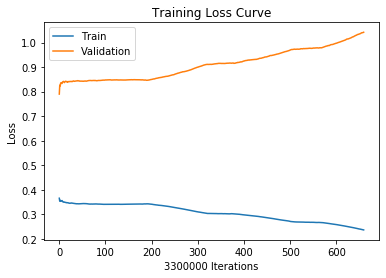

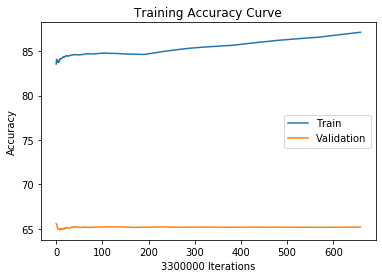

 49%|████▉     | 461710/946094 [1:04:40<1:22:33, 97.78it/s]

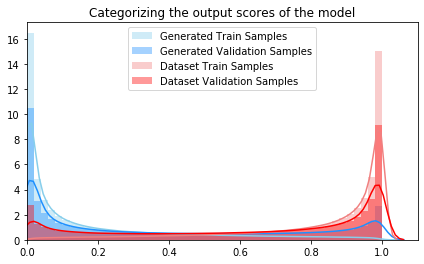

 49%|████▉     | 461736/946094 [1:04:49<85:58:51,  1.56it/s] 

Training Accuracy at epoch 21: 87.14739393939394
Validation Accuracy epoch 21: 65.18024242424242


 54%|█████▍    | 511713/946094 [1:11:44<46:33, 155.48it/s]  

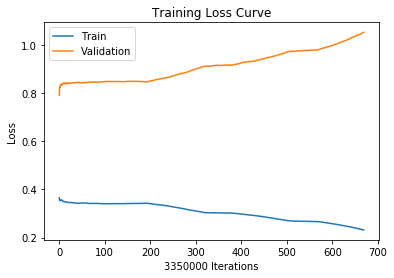

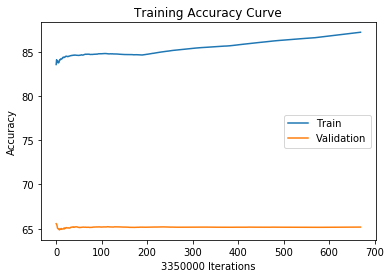

 54%|█████▍    | 511713/946094 [1:12:00<46:33, 155.48it/s]

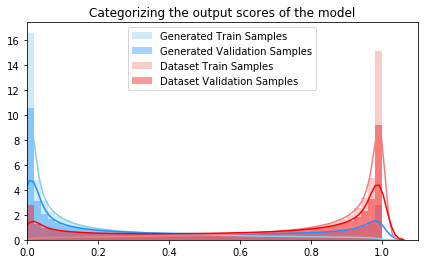

 54%|█████▍    | 511718/946094 [1:12:07<169:24:05,  1.40s/it]

Training Accuracy at epoch 21: 87.20820895522388
Validation Accuracy epoch 21: 65.17958208955224


 59%|█████▉    | 561703/946094 [1:19:02<53:36, 119.50it/s]   

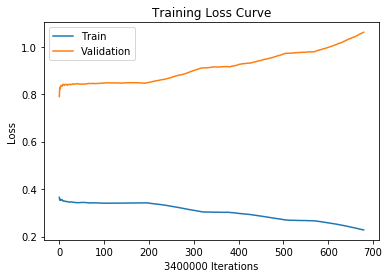

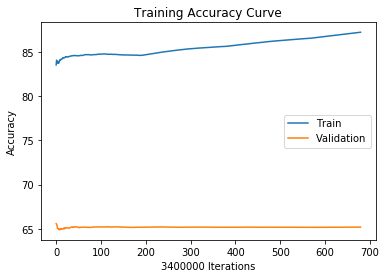

 59%|█████▉    | 561703/946094 [1:19:20<53:36, 119.50it/s]

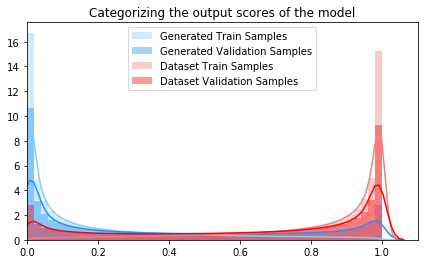

 59%|█████▉    | 561736/946094 [1:19:28<38:31:09,  2.77it/s]

Training Accuracy at epoch 21: 87.26220588235294
Validation Accuracy epoch 21: 65.17658823529412


 65%|██████▍   | 611717/946094 [1:26:08<1:01:41, 90.34it/s] 

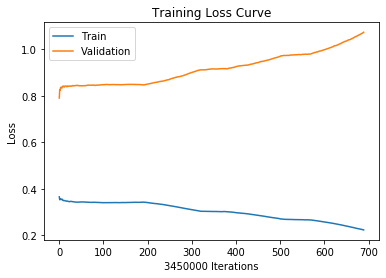

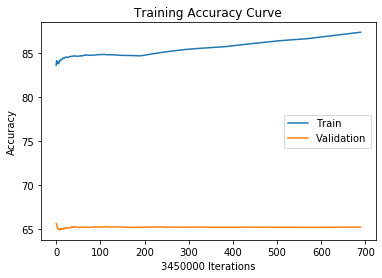

 65%|██████▍   | 611717/946094 [1:26:20<1:01:41, 90.34it/s]

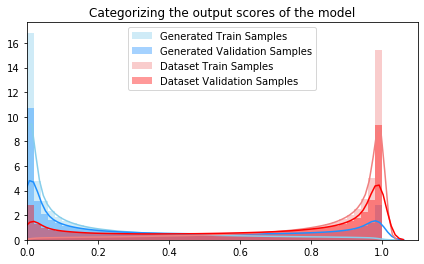

 65%|██████▍   | 611736/946094 [1:26:32<474:53:40,  5.11s/it]

Training Accuracy at epoch 21: 87.32031884057972
Validation Accuracy epoch 21: 65.17666666666666


 70%|██████▉   | 661700/946094 [1:33:12<32:46, 144.65it/s]   

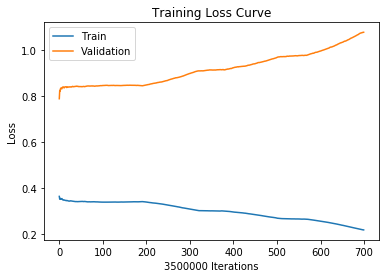

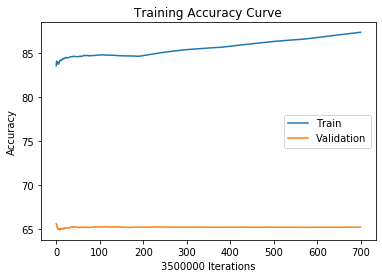

 70%|██████▉   | 661700/946094 [1:33:30<32:46, 144.65it/s]

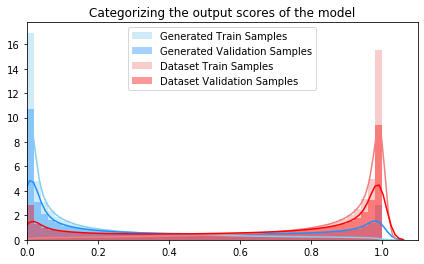

 70%|██████▉   | 661735/946094 [1:33:38<24:13:45,  3.26it/s]

Training Accuracy at epoch 21: 87.37477142857144
Validation Accuracy epoch 21: 65.17608571428572


 75%|███████▌  | 711702/946094 [1:40:17<41:14, 94.71it/s]   

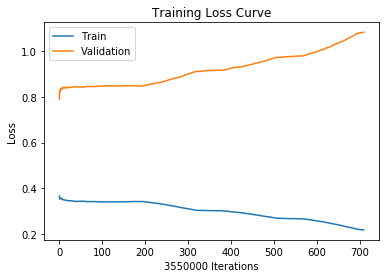

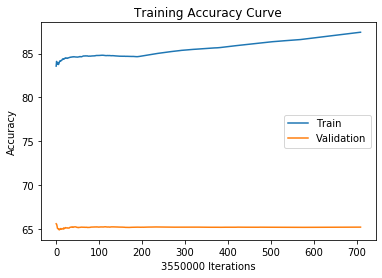

 75%|███████▌  | 711702/946094 [1:40:30<41:14, 94.71it/s]

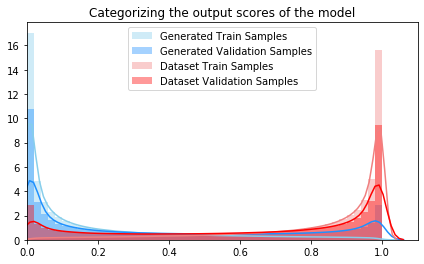

 75%|███████▌  | 711735/946094 [1:40:42<21:38:16,  3.01it/s]

Training Accuracy at epoch 21: 87.42769014084507
Validation Accuracy epoch 21: 65.1774366197183


 81%|████████  | 761709/946094 [1:47:20<18:34, 165.43it/s]  

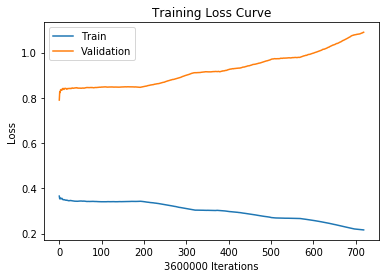

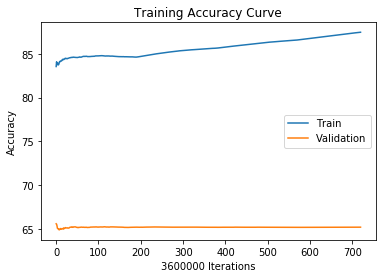

 81%|████████  | 761709/946094 [1:47:30<18:34, 165.43it/s]

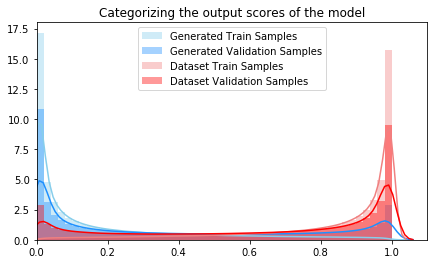

 81%|████████  | 761735/946094 [1:47:46<31:44:57,  1.61it/s]

Training Accuracy at epoch 21: 87.48325
Validation Accuracy epoch 21: 65.17358333333334


 86%|████████▌ | 811706/946094 [1:54:23<16:19, 137.26it/s]  

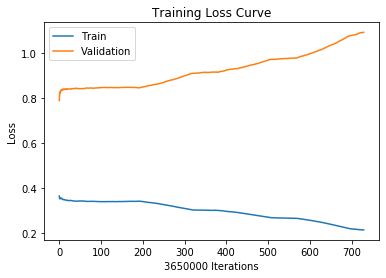

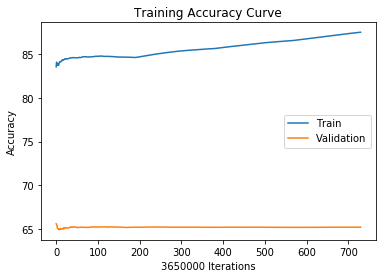

 86%|████████▌ | 811706/946094 [1:54:40<16:19, 137.26it/s]

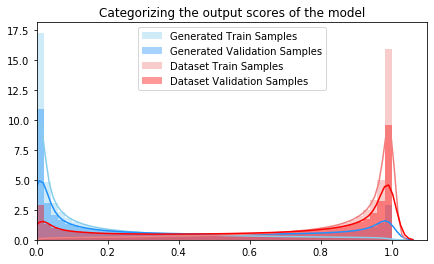

 86%|████████▌ | 811736/946094 [1:54:48<16:39:30,  2.24it/s]

Training Accuracy at epoch 21: 87.53413698630138
Validation Accuracy epoch 21: 65.174


 91%|█████████ | 861705/946094 [2:01:26<13:16, 105.90it/s]  

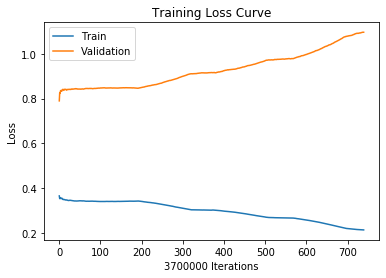

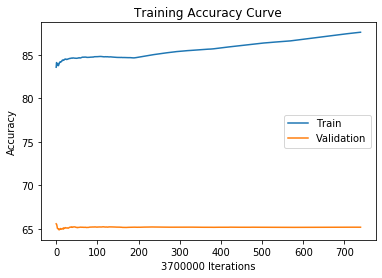

 91%|█████████ | 861705/946094 [2:01:40<13:16, 105.90it/s]

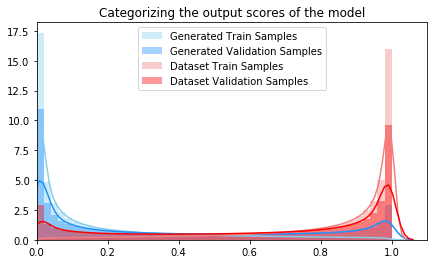

 91%|█████████ | 861735/946094 [2:01:52<10:19:22,  2.27it/s]

Training Accuracy at epoch 21: 87.58543243243243
Validation Accuracy epoch 21: 65.17048648648648


 96%|█████████▋| 911712/946094 [2:08:27<03:36, 159.07it/s]  

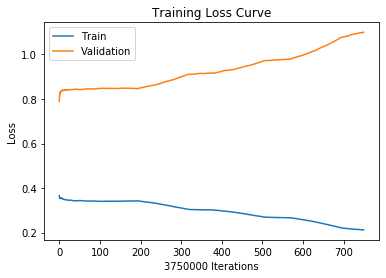

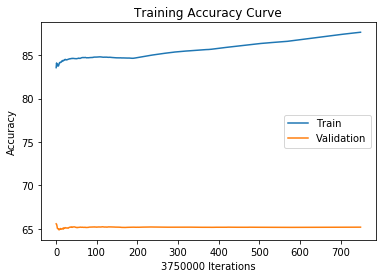

 96%|█████████▋| 911712/946094 [2:08:40<03:36, 159.07it/s]

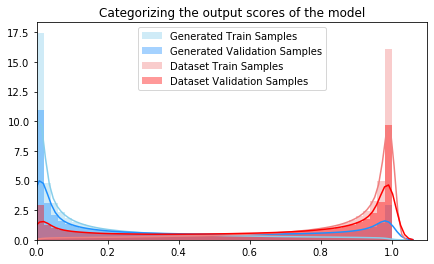

 96%|█████████▋| 911718/946094 [2:08:53<12:25:15,  1.30s/it]

Training Accuracy at epoch 21: 87.63893333333333
Validation Accuracy epoch 21: 65.17709333333333


  0%|          | 19/946094 [00:00<1:26:00, 183.34it/s]

Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/06172020.pth
Starting epoch: 22  with learning rate:  [0.09000000000000001]


  2%|▏         | 15605/946094 [02:02<2:05:53, 123.18it/s]

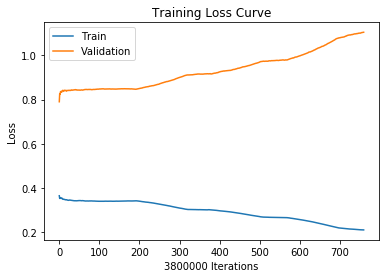

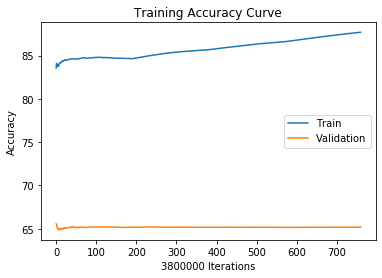

  2%|▏         | 15605/946094 [02:20<2:05:53, 123.18it/s]

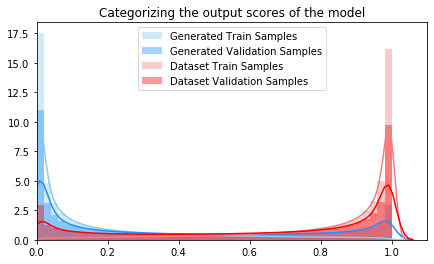

  2%|▏         | 15642/946094 [02:30<80:01:52,  3.23it/s] 

Training Accuracy at epoch 22: 87.69052631578947
Validation Accuracy epoch 22: 65.17784210526315


  7%|▋         | 65605/946094 [09:04<1:24:27, 173.75it/s]

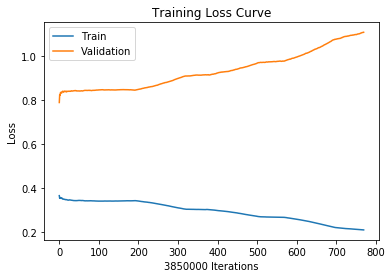

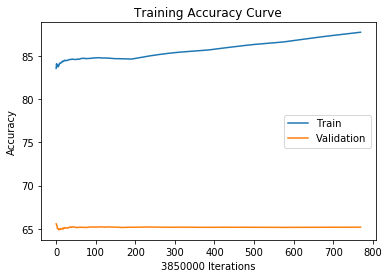

  7%|▋         | 65605/946094 [09:20<1:24:27, 173.75it/s]

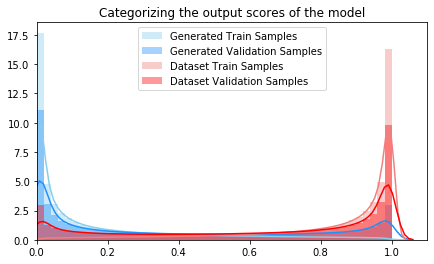

  7%|▋         | 65659/946094 [09:31<52:39:11,  4.64it/s] 

Training Accuracy at epoch 22: 87.74792207792208
Validation Accuracy epoch 22: 65.17709090909091


 12%|█▏        | 115612/946094 [16:07<1:26:13, 160.52it/s]

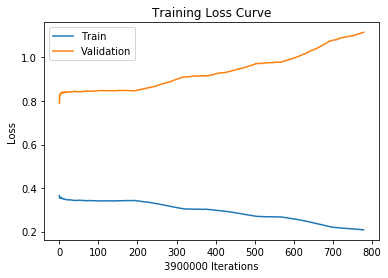

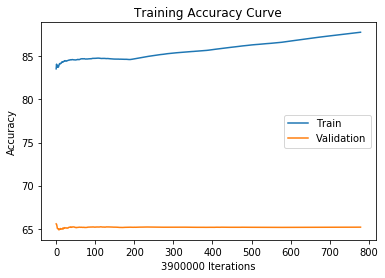

 12%|█▏        | 115612/946094 [16:20<1:26:13, 160.52it/s]

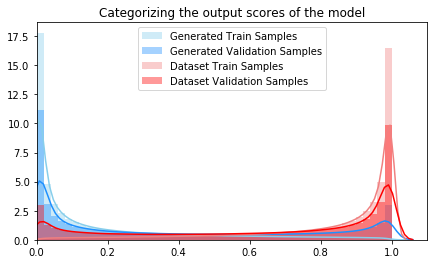

 12%|█▏        | 115642/946094 [16:36<115:07:51,  2.00it/s]

Training Accuracy at epoch 22: 87.80561538461538
Validation Accuracy epoch 22: 65.17884615384615


 18%|█▊        | 165607/946094 [23:13<2:00:55, 107.58it/s] 

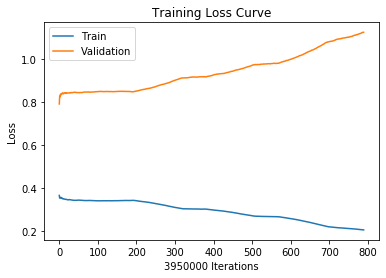

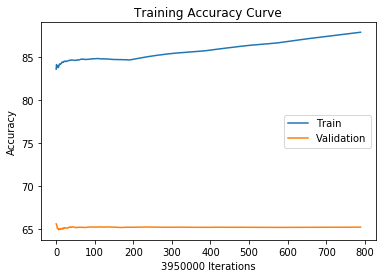

 18%|█▊        | 165607/946094 [23:30<2:00:55, 107.58it/s]

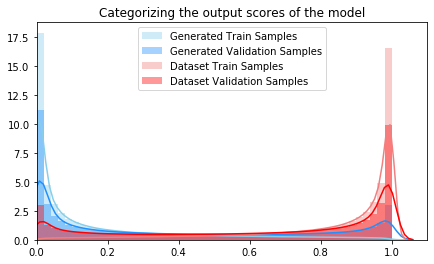

 18%|█▊        | 165642/946094 [23:40<75:02:42,  2.89it/s] 

Training Accuracy at epoch 22: 87.86146835443039
Validation Accuracy epoch 22: 65.1807088607595


 23%|██▎       | 215623/946094 [30:17<1:14:27, 163.53it/s]

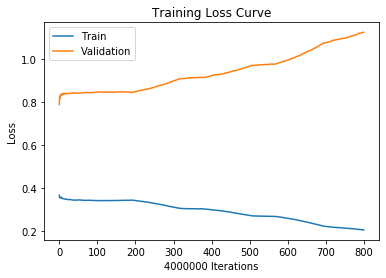

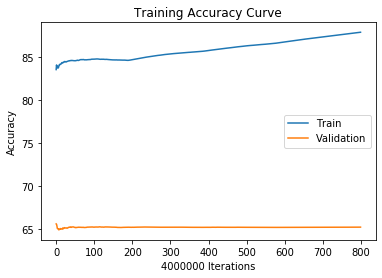

 23%|██▎       | 215623/946094 [30:30<1:14:27, 163.53it/s]

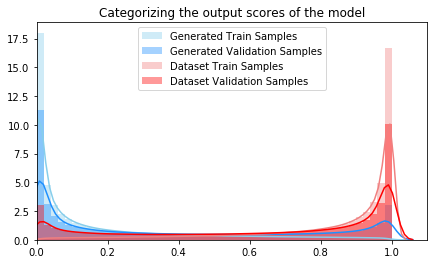

 23%|██▎       | 215644/946094 [30:46<1244:14:29,  6.13s/it]

Training Accuracy at epoch 22: 87.916125
Validation Accuracy epoch 22: 65.1839


 28%|██▊       | 265619/946094 [37:22<1:22:26, 137.57it/s]  

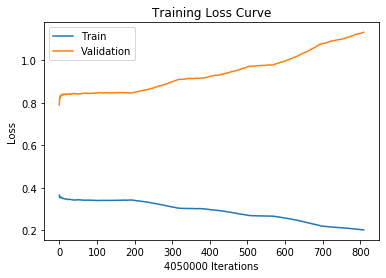

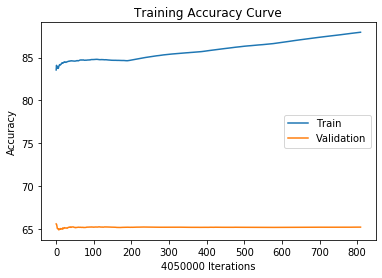

 28%|██▊       | 265619/946094 [37:40<1:22:26, 137.57it/s]

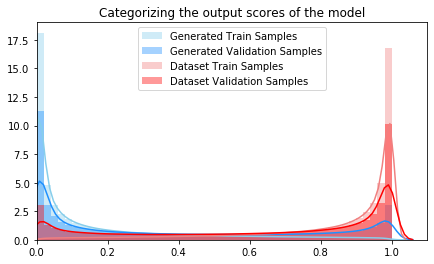

 28%|██▊       | 265644/946094 [37:51<227:10:35,  1.20s/it]

Training Accuracy at epoch 22: 87.96730864197531
Validation Accuracy epoch 22: 65.18454320987654


 33%|███▎      | 315606/946094 [44:27<1:55:59, 90.59it/s]  

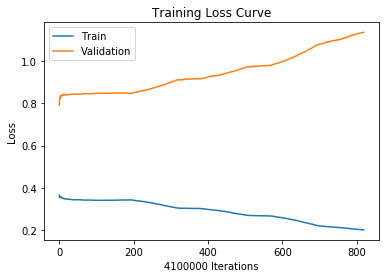

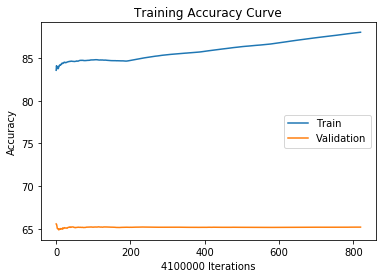

 33%|███▎      | 315606/946094 [44:40<1:55:59, 90.59it/s]

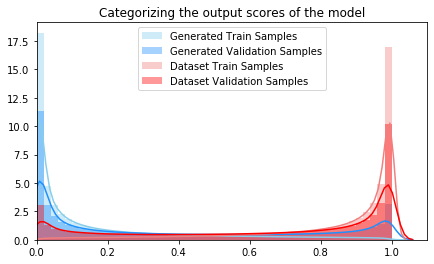

 33%|███▎      | 315644/946094 [44:58<64:24:42,  2.72it/s]

Training Accuracy at epoch 22: 88.01770731707317
Validation Accuracy epoch 22: 65.18658536585366


 39%|███▊      | 365612/946094 [51:34<1:00:48, 159.08it/s]

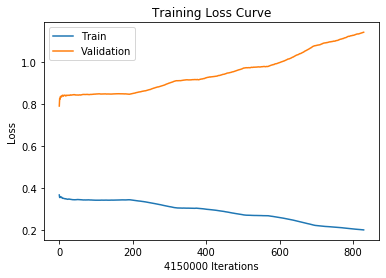

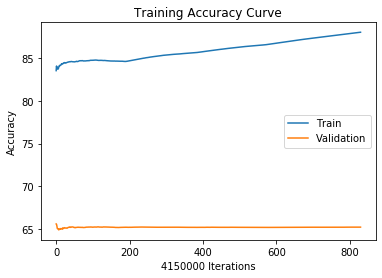

 39%|███▊      | 365612/946094 [51:50<1:00:48, 159.08it/s]

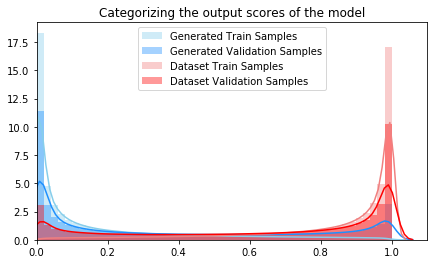

 39%|███▊      | 365624/946094 [52:03<116:59:24,  1.38it/s]

Training Accuracy at epoch 22: 88.06759036144578
Validation Accuracy epoch 22: 65.18568674698795


 44%|████▍     | 415619/946094 [58:40<1:05:53, 134.17it/s] 

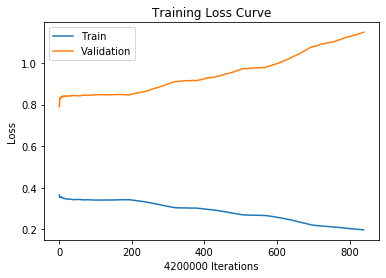

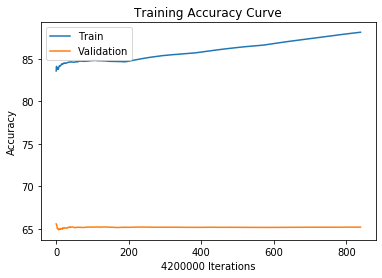

 44%|████▍     | 415619/946094 [59:00<1:05:53, 134.17it/s]

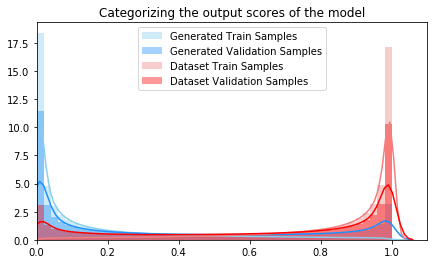

 44%|████▍     | 415641/946094 [59:10<188:05:34,  1.28s/it]

Training Accuracy at epoch 22: 88.11661904761905
Validation Accuracy epoch 22: 65.18504761904762


 49%|████▉     | 465621/946094 [1:05:46<1:28:32, 90.44it/s] 

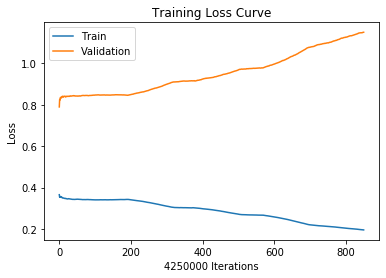

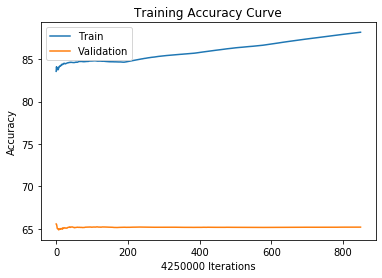

 49%|████▉     | 465621/946094 [1:06:00<1:28:32, 90.44it/s]

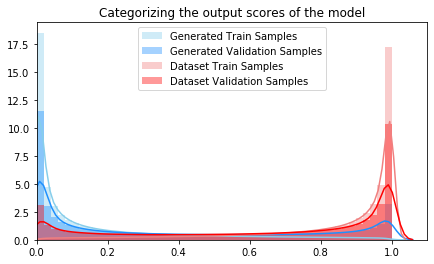

 49%|████▉     | 465642/946094 [1:06:17<288:27:51,  2.16s/it]

Training Accuracy at epoch 22: 88.16938823529412
Validation Accuracy epoch 22: 65.18745882352941


 54%|█████▍    | 515614/946094 [1:12:55<52:52, 135.68it/s]   

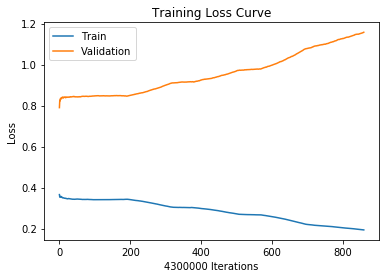

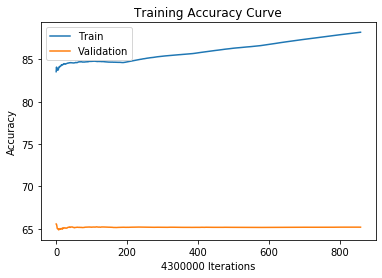

 54%|█████▍    | 515614/946094 [1:13:10<52:52, 135.68it/s]

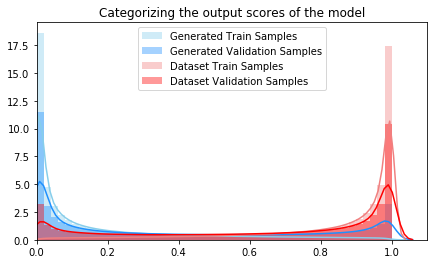

 55%|█████▍    | 515642/946094 [1:13:26<79:04:56,  1.51it/s] 

Training Accuracy at epoch 22: 88.22041860465116
Validation Accuracy epoch 22: 65.18304651162791


 60%|█████▉    | 565611/946094 [1:20:01<58:54, 107.66it/s]  

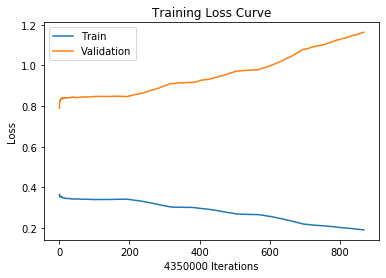

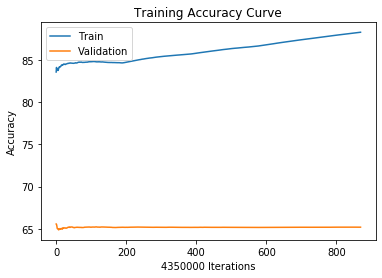

 60%|█████▉    | 565611/946094 [1:20:20<58:54, 107.66it/s]

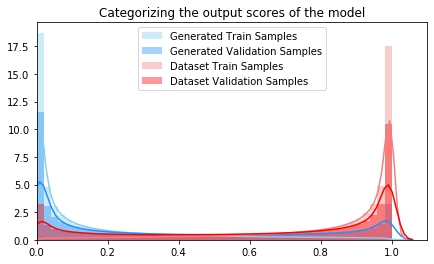

 60%|█████▉    | 565642/946094 [1:20:31<52:04:57,  2.03it/s]

Training Accuracy at epoch 22: 88.26947126436782
Validation Accuracy epoch 22: 65.18411494252874


 65%|██████▌   | 615622/946094 [1:27:06<33:19, 165.28it/s]  

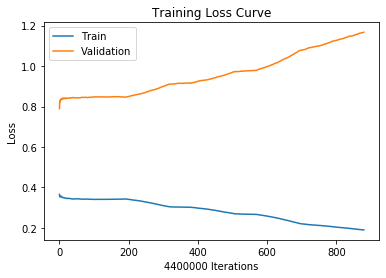

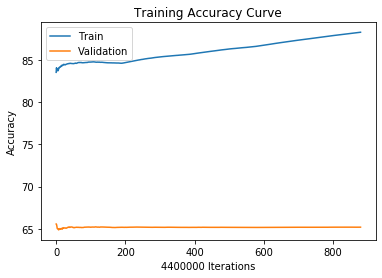

 65%|██████▌   | 615622/946094 [1:27:20<33:19, 165.28it/s]

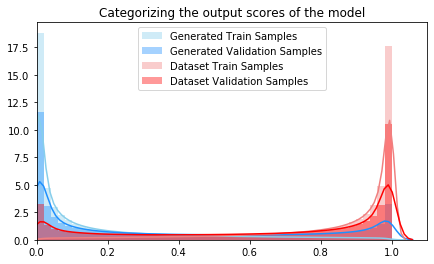

 65%|██████▌   | 615641/946094 [1:27:38<311:01:17,  3.39s/it]

Training Accuracy at epoch 22: 88.31684090909091
Validation Accuracy epoch 22: 65.18522727272727


 70%|███████   | 665621/946094 [1:34:17<32:00, 146.05it/s]   

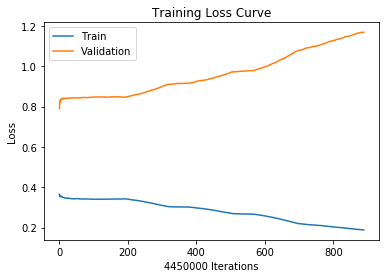

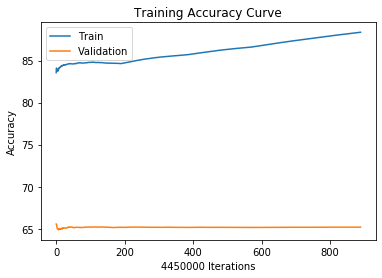

 70%|███████   | 665621/946094 [1:34:30<32:00, 146.05it/s]

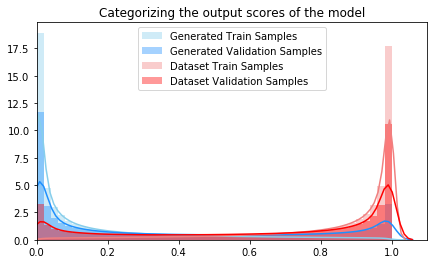

 70%|███████   | 665640/946094 [1:34:48<170:25:55,  2.19s/it]

Training Accuracy at epoch 22: 88.36186516853932
Validation Accuracy epoch 22: 65.18829213483146


 76%|███████▌  | 715613/946094 [1:41:31<37:54, 101.33it/s]   

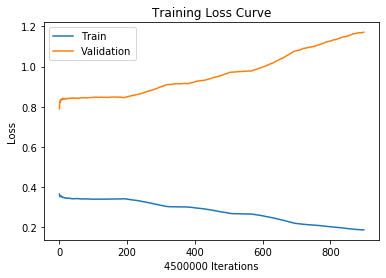

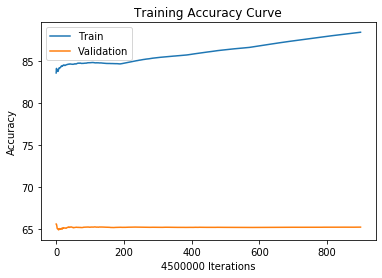

 76%|███████▌  | 715613/946094 [1:41:50<37:54, 101.33it/s]

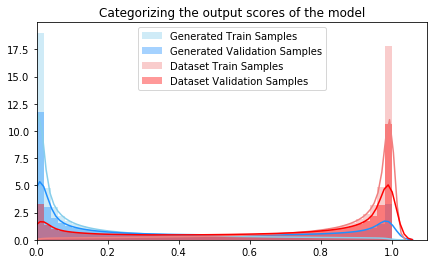

 76%|███████▌  | 715642/946094 [1:42:04<40:05:17,  1.60it/s]

Training Accuracy at epoch 22: 88.40817777777778
Validation Accuracy epoch 22: 65.19135555555556


 81%|████████  | 765619/946094 [1:48:41<18:56, 158.79it/s]  

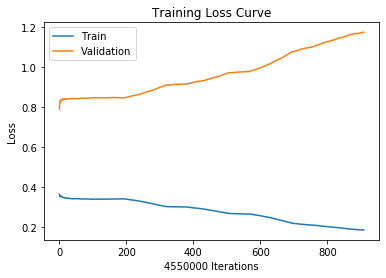

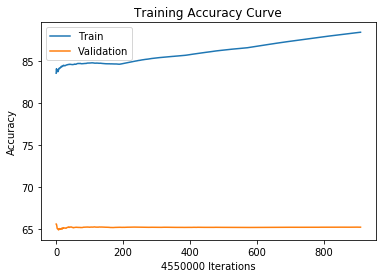

 81%|████████  | 765619/946094 [1:49:00<18:56, 158.79it/s]

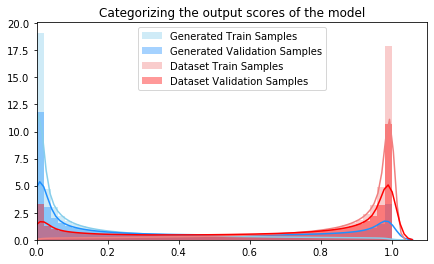

 81%|████████  | 765624/946094 [1:49:13<97:33:14,  1.95s/it]

Training Accuracy at epoch 22: 88.45254945054945
Validation Accuracy epoch 22: 65.18663736263736


 86%|████████▌ | 815611/946094 [1:55:49<18:08, 119.84it/s]  

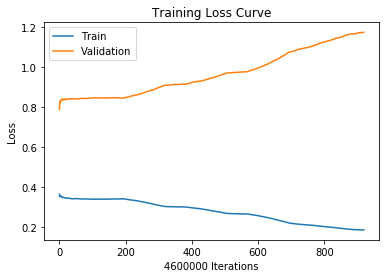

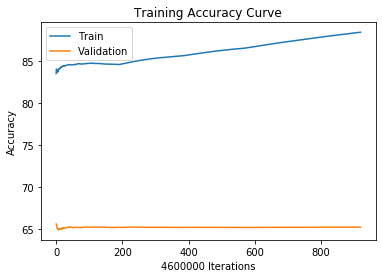

 86%|████████▌ | 815611/946094 [1:56:00<18:08, 119.84it/s]

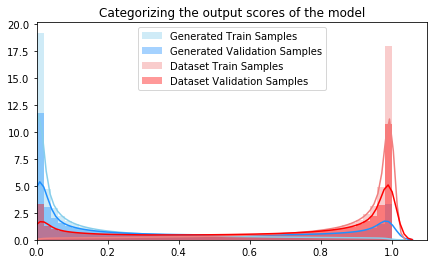

 86%|████████▌ | 815642/946094 [1:56:23<19:52:50,  1.82it/s]

Training Accuracy at epoch 22: 88.49695652173914
Validation Accuracy epoch 22: 65.1850652173913


 91%|█████████▏| 865620/946094 [2:03:02<14:43, 91.11it/s]   

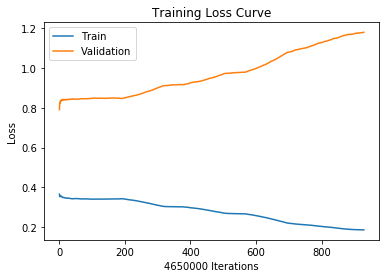

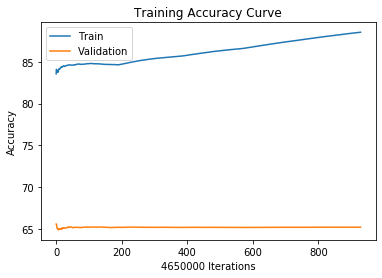

 91%|█████████▏| 865620/946094 [2:03:20<14:43, 91.11it/s]

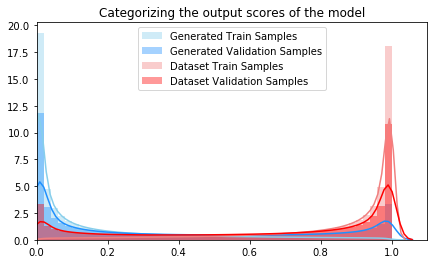

 91%|█████████▏| 865642/946094 [2:03:35<39:11:46,  1.75s/it]

Training Accuracy at epoch 22: 88.54161290322581
Validation Accuracy epoch 22: 65.18406451612903


 97%|█████████▋| 915609/946094 [2:10:11<03:23, 149.68it/s]  

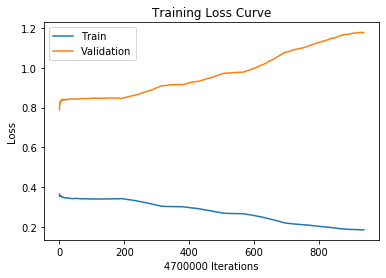

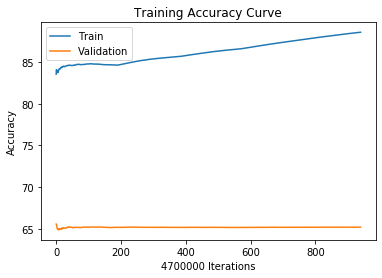

 97%|█████████▋| 915609/946094 [2:10:30<03:23, 149.68it/s]

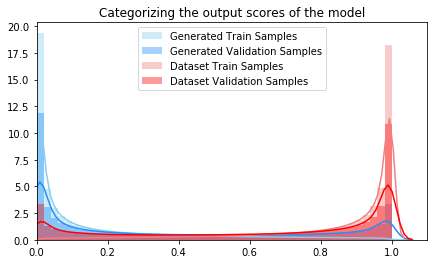

 97%|█████████▋| 915642/946094 [2:10:44<3:53:39,  2.17it/s]

Training Accuracy at epoch 22: 88.58485106382979
Validation Accuracy epoch 22: 65.18655319148937


  0%|          | 19/946094 [00:00<1:23:11, 189.53it/s]

Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/06172020.pth
Starting epoch: 23  with learning rate:  [0.09000000000000001]


  2%|▏         | 19527/946094 [02:36<2:10:29, 118.35it/s]

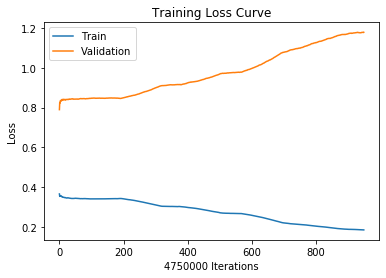

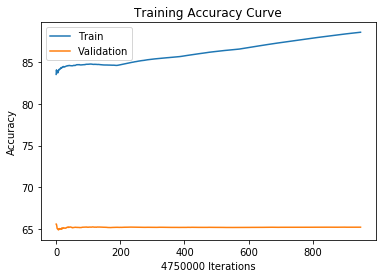

  2%|▏         | 19527/946094 [02:50<2:10:29, 118.35it/s]

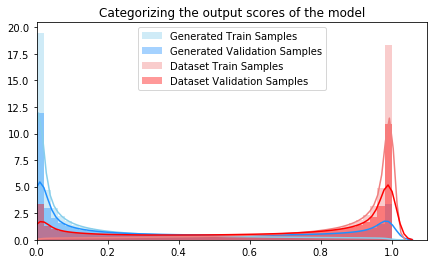

  2%|▏         | 19548/946094 [03:10<621:35:56,  2.42s/it]

Training Accuracy at epoch 23: 88.626
Validation Accuracy epoch 23: 65.1877052631579


  7%|▋         | 69519/946094 [09:46<1:28:50, 164.44it/s] 

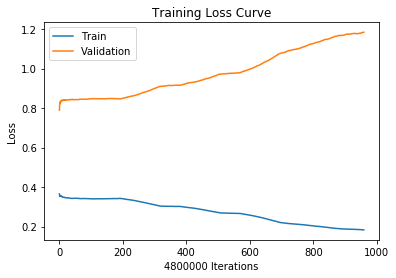

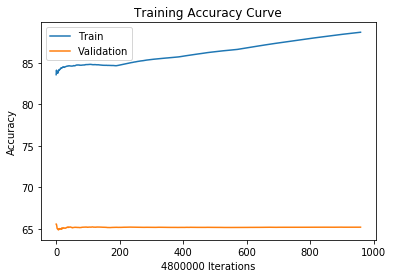

  7%|▋         | 69519/946094 [10:00<1:28:50, 164.44it/s]

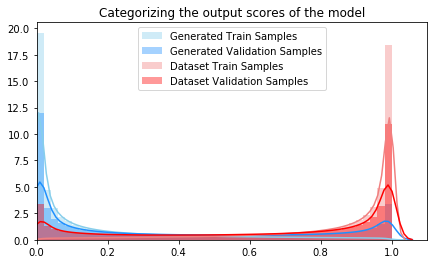

  7%|▋         | 69547/946094 [10:20<160:20:24,  1.52it/s]

Training Accuracy at epoch 23: 88.67077083333334
Validation Accuracy epoch 23: 65.18939583333334


 13%|█▎        | 119518/946094 [16:57<1:40:10, 137.52it/s]

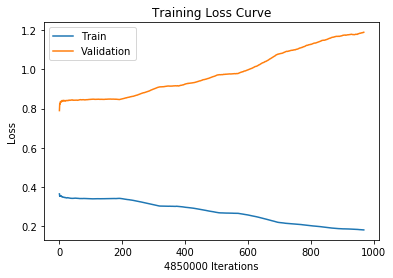

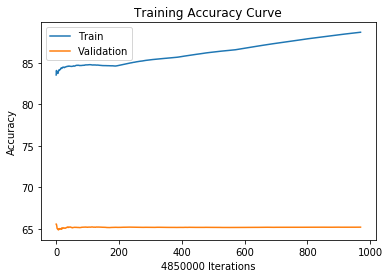

 13%|█▎        | 119518/946094 [17:10<1:40:10, 137.52it/s]

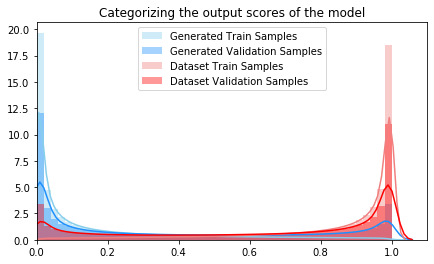

 13%|█▎        | 119548/946094 [17:32<142:02:06,  1.62it/s]

Training Accuracy at epoch 23: 88.71523711340207
Validation Accuracy epoch 23: 65.19218556701031


 18%|█▊        | 169518/946094 [24:07<2:05:34, 103.07it/s] 

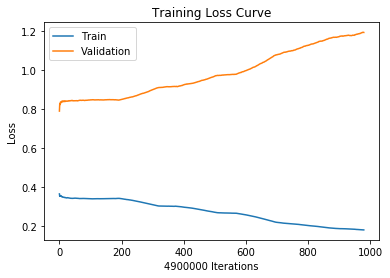

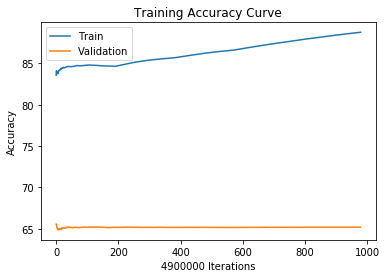

 18%|█▊        | 169518/946094 [24:20<2:05:34, 103.07it/s]

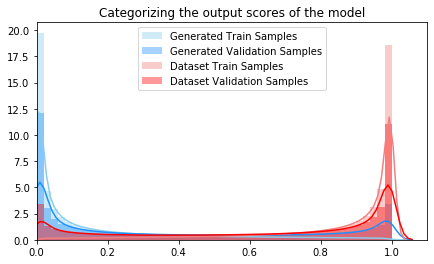

 18%|█▊        | 169548/946094 [24:42<129:49:13,  1.66it/s]

Training Accuracy at epoch 23: 88.75916326530613
Validation Accuracy epoch 23: 65.19579591836735


 23%|██▎       | 219522/946094 [31:17<1:16:09, 159.01it/s] 

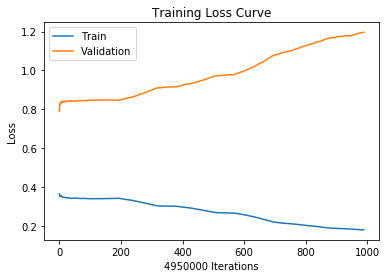

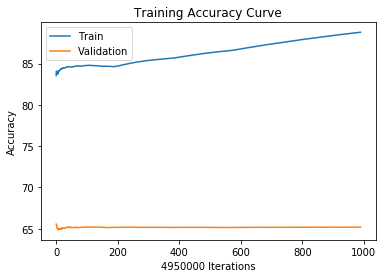

 23%|██▎       | 219522/946094 [31:30<1:16:09, 159.01it/s]

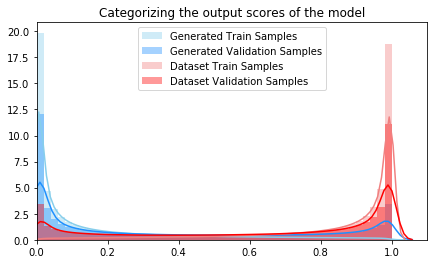

 23%|██▎       | 219530/946094 [31:53<270:22:48,  1.34s/it]

Training Accuracy at epoch 23: 88.80240404040404
Validation Accuracy epoch 23: 65.19894949494949


 28%|██▊       | 269517/946094 [38:27<1:31:39, 123.02it/s] 

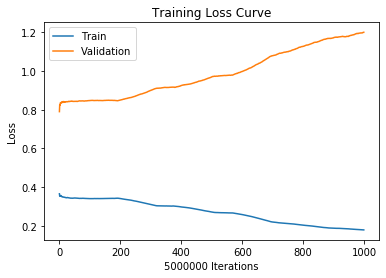

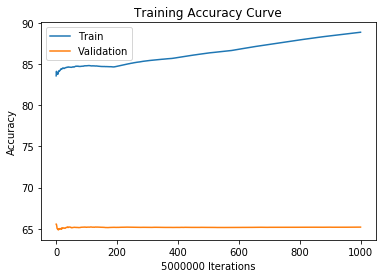

 28%|██▊       | 269517/946094 [38:40<1:31:39, 123.02it/s]

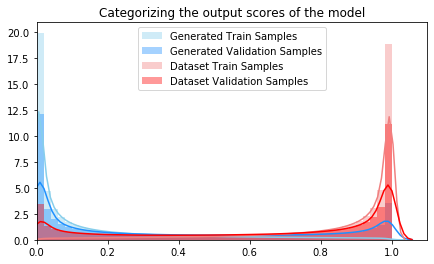

 28%|██▊       | 269548/946094 [39:02<106:32:03,  1.76it/s]

Training Accuracy at epoch 23: 88.84664
Validation Accuracy epoch 23: 65.19892


 34%|███▍      | 319520/946094 [45:37<1:54:48, 90.96it/s]  

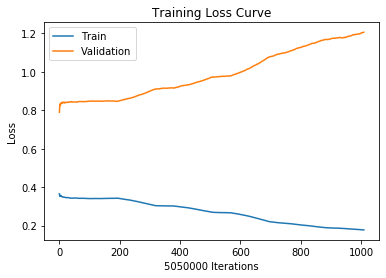

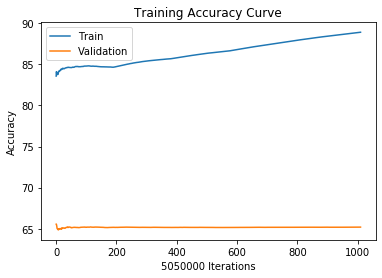

 34%|███▍      | 319520/946094 [45:50<1:54:48, 90.96it/s]

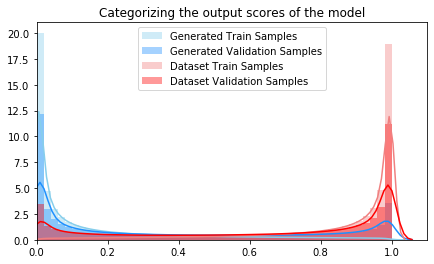

 34%|███▍      | 319548/946094 [46:14<134:04:35,  1.30it/s]

Training Accuracy at epoch 23: 88.88970297029702
Validation Accuracy epoch 23: 65.19952475247524


 39%|███▉      | 369518/946094 [52:48<1:04:09, 149.80it/s] 

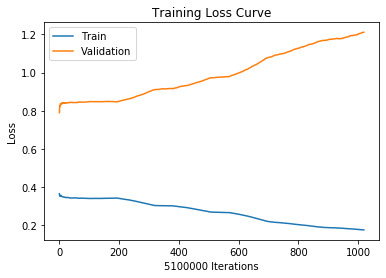

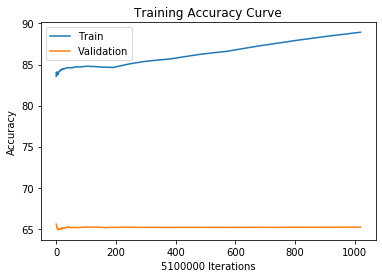

 39%|███▉      | 369518/946094 [53:00<1:04:09, 149.80it/s]

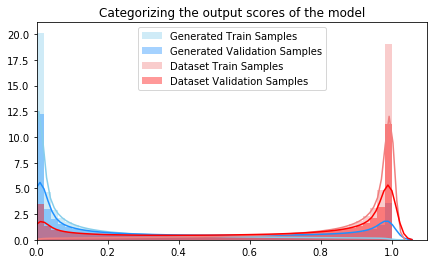

 39%|███▉      | 369548/946094 [53:23<100:05:50,  1.60it/s]

Training Accuracy at epoch 23: 88.93286274509803
Validation Accuracy epoch 23: 65.20045098039216


 44%|████▍     | 419518/946094 [59:58<1:21:12, 108.06it/s] 

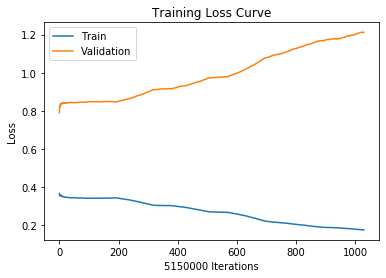

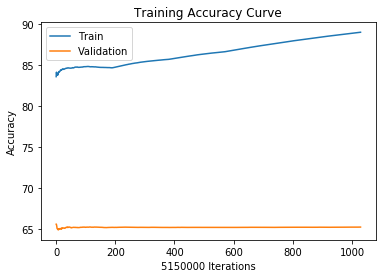

 44%|████▍     | 419518/946094 [1:00:10<1:21:12, 108.06it/s]

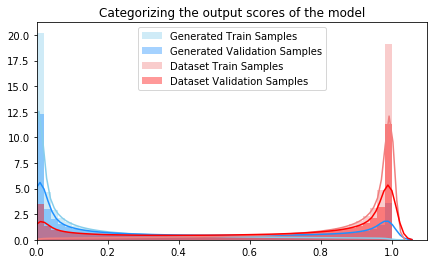

 44%|████▍     | 419548/946094 [1:00:35<96:05:49,  1.52it/s] 

Training Accuracy at epoch 23: 88.97681553398058
Validation Accuracy epoch 23: 65.2053786407767


 50%|████▉     | 469522/946094 [1:07:10<48:41, 163.12it/s]  

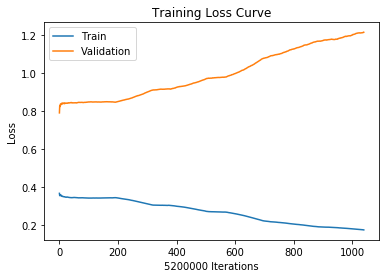

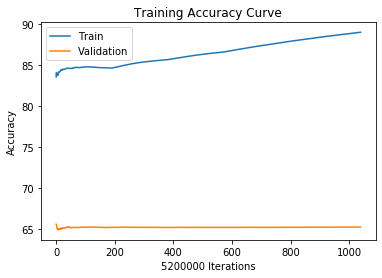

 50%|████▉     | 469522/946094 [1:07:20<48:41, 163.12it/s]

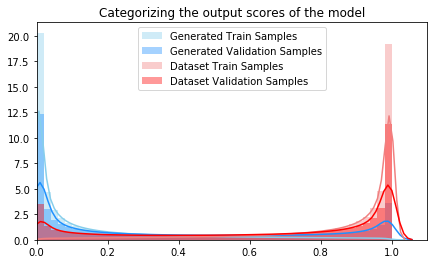

 50%|████▉     | 469548/946094 [1:07:47<130:38:44,  1.01it/s]

Training Accuracy at epoch 23: 89.02032692307692
Validation Accuracy epoch 23: 65.20857692307692


 55%|█████▍    | 519524/946094 [1:14:33<51:30, 138.04it/s]   

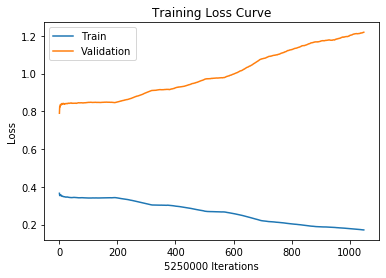

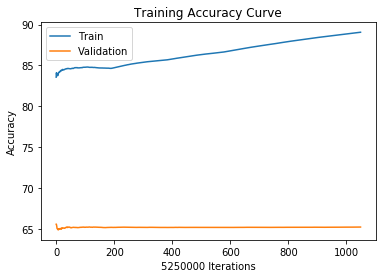

 55%|█████▍    | 519524/946094 [1:14:50<51:30, 138.04it/s]

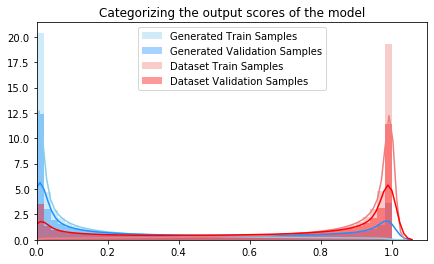

 55%|█████▍    | 519548/946094 [1:15:11<157:18:48,  1.33s/it]

Training Accuracy at epoch 23: 89.06220952380953
Validation Accuracy epoch 23: 65.21017142857143


 60%|██████    | 569523/946094 [1:21:50<59:38, 105.24it/s]   

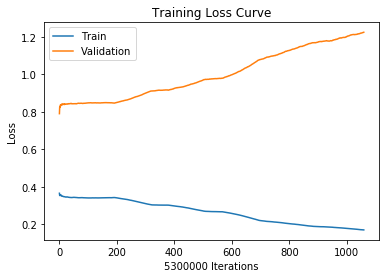

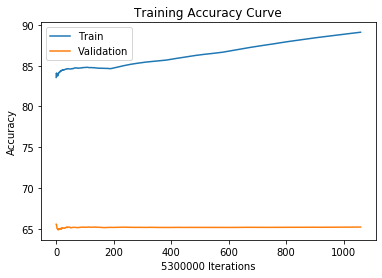

 60%|██████    | 569523/946094 [1:22:00<59:38, 105.24it/s]

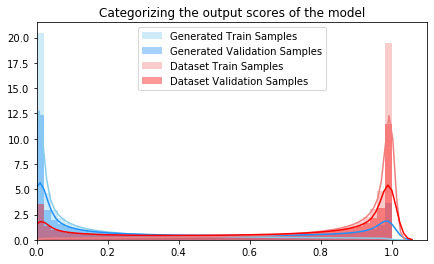

 60%|██████    | 569548/946094 [1:22:26<116:11:54,  1.11s/it]

Training Accuracy at epoch 23: 89.10164150943396
Validation Accuracy epoch 23: 65.21041509433962


 65%|██████▌   | 619519/946094 [1:29:03<34:34, 157.45it/s]   

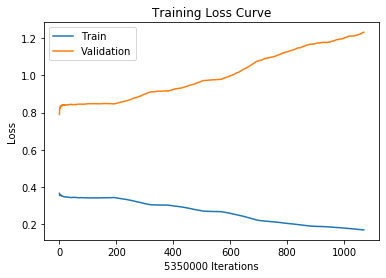

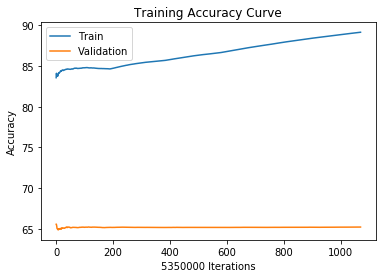

 65%|██████▌   | 619519/946094 [1:29:20<34:34, 157.45it/s]

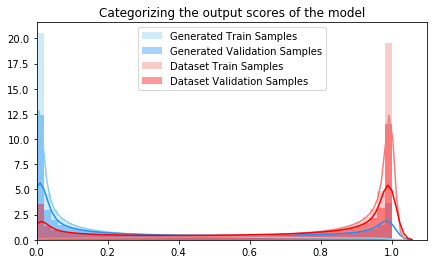

 65%|██████▌   | 619530/946094 [1:29:42<96:24:56,  1.06s/it]

Training Accuracy at epoch 23: 89.14284112149532
Validation Accuracy epoch 23: 65.21140186915888


 71%|███████   | 669519/946094 [1:36:18<37:24, 123.23it/s]  

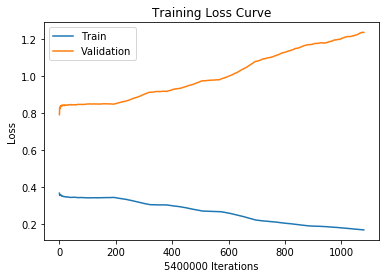

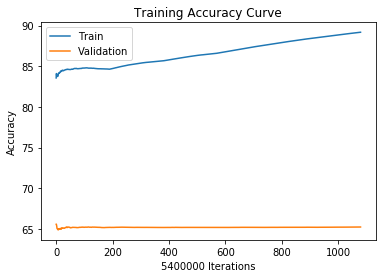

 71%|███████   | 669519/946094 [1:36:30<37:24, 123.23it/s]

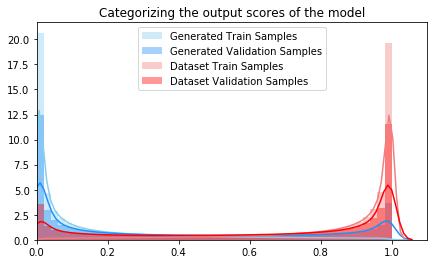

 71%|███████   | 669548/946094 [1:36:56<56:06:33,  1.37it/s]

Training Accuracy at epoch 23: 89.18296296296296
Validation Accuracy epoch 23: 65.2172037037037


 76%|███████▌  | 719517/946094 [1:43:32<43:22, 87.08it/s]   

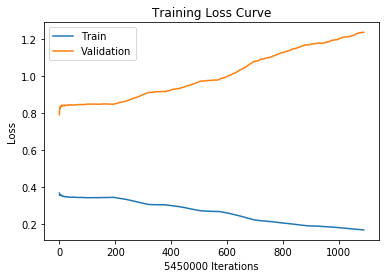

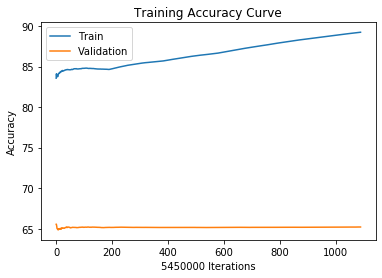

 76%|███████▌  | 719517/946094 [1:43:50<43:22, 87.08it/s]

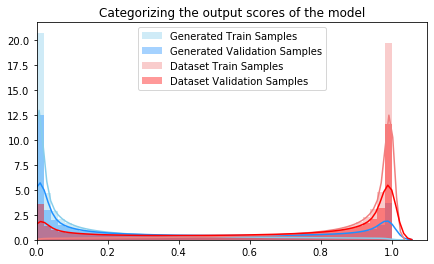

 76%|███████▌  | 719548/946094 [1:44:12<40:54:02,  1.54it/s]

Training Accuracy at epoch 23: 89.22291743119266
Validation Accuracy epoch 23: 65.2185504587156


 81%|████████▏ | 769525/946094 [1:50:52<19:53, 147.97it/s]  

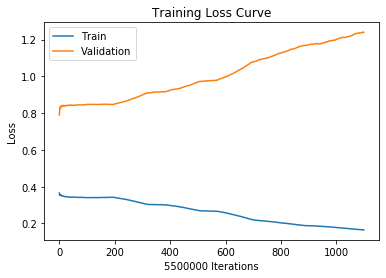

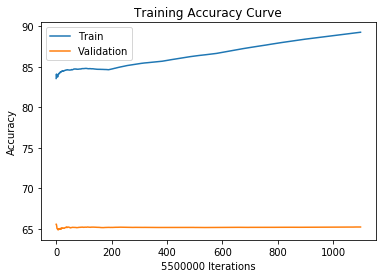

 81%|████████▏ | 769525/946094 [1:51:10<19:53, 147.97it/s]

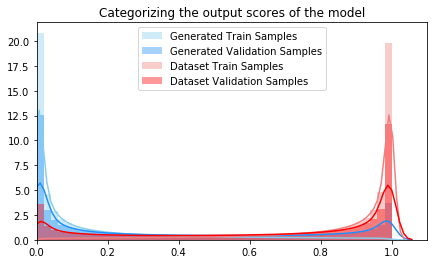

 81%|████████▏ | 769546/946094 [1:51:33<85:43:31,  1.75s/it] 

Training Accuracy at epoch 23: 89.26378181818181
Validation Accuracy epoch 23: 65.21930909090909


 87%|████████▋ | 819529/946094 [1:58:23<18:14, 115.66it/s]  

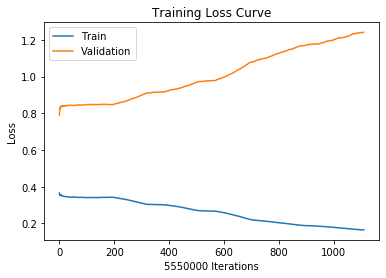

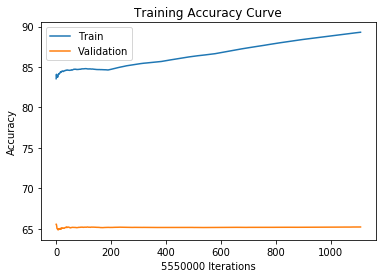

 87%|████████▋ | 819529/946094 [1:58:40<18:14, 115.66it/s]

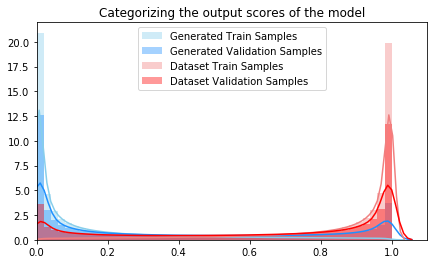

 87%|████████▋ | 819548/946094 [1:59:03<294:55:35,  8.39s/it]

Training Accuracy at epoch 23: 89.30185585585586
Validation Accuracy epoch 23: 65.22275675675675


 92%|█████████▏| 869512/946094 [2:05:41<08:05, 157.84it/s]   

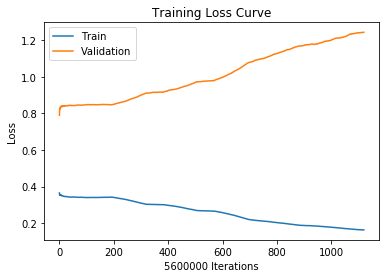

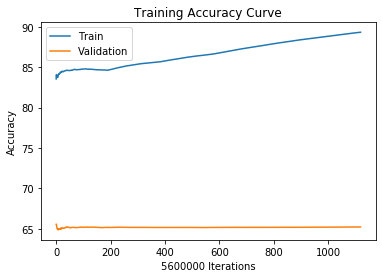

 92%|█████████▏| 869512/946094 [2:06:00<08:05, 157.84it/s]

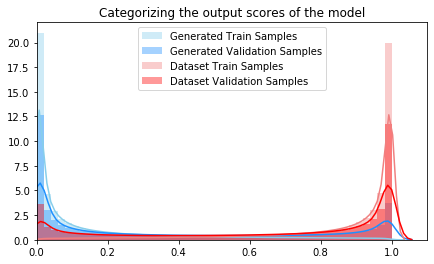

 92%|█████████▏| 869548/946094 [2:06:21<9:58:43,  2.13it/s] 

Training Accuracy at epoch 23: 89.33910714285715
Validation Accuracy epoch 23: 65.223875


 97%|█████████▋| 919513/946094 [2:13:11<03:16, 135.35it/s] 

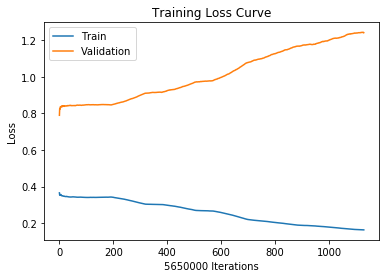

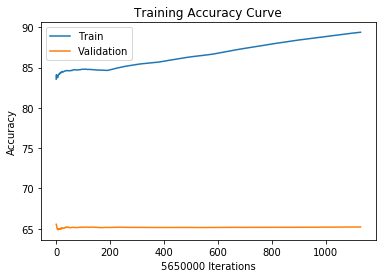

 97%|█████████▋| 919513/946094 [2:13:30<03:16, 135.35it/s]

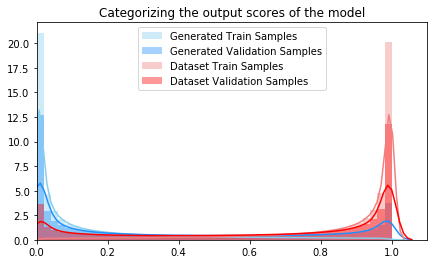

 97%|█████████▋| 919548/946094 [2:13:53<3:49:03,  1.93it/s]

Training Accuracy at epoch 23: 89.376
Validation Accuracy epoch 23: 65.2273628318584


  0%|          | 16/946094 [00:00<1:42:15, 154.20it/s]

Saving to:  model_checkpoints/binary/SingleAlphabetComplexNet/06172020.pth
Starting epoch: 24  with learning rate:  [0.07290000000000002]


  2%|▏         | 23426/946094 [03:07<2:32:00, 101.16it/s]

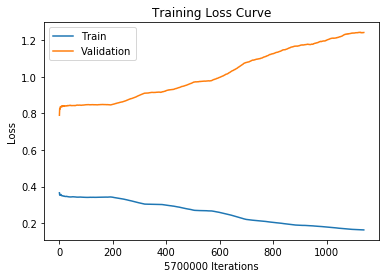

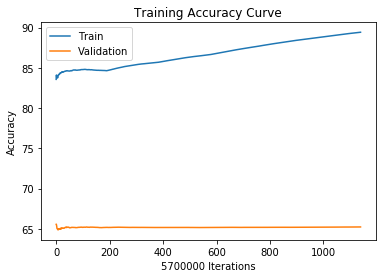

  2%|▏         | 23426/946094 [03:20<2:32:00, 101.16it/s]

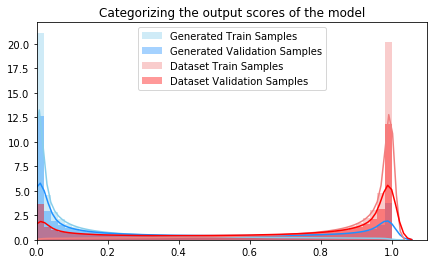

  2%|▏         | 23454/946094 [03:47<217:02:36,  1.18it/s]

Training Accuracy at epoch 24: 89.41291228070176
Validation Accuracy epoch 24: 65.2279298245614


  8%|▊         | 73419/946094 [10:27<1:32:48, 156.71it/s] 

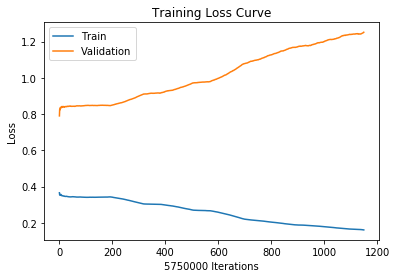

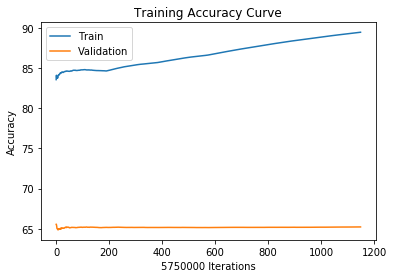

  8%|▊         | 73419/946094 [10:40<1:32:48, 156.71it/s]

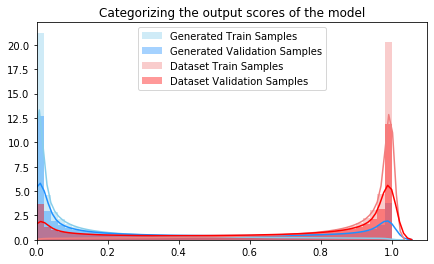

  8%|▊         | 73436/946094 [11:08<180:04:16,  1.35it/s]

Training Accuracy at epoch 24: 89.45504347826088
Validation Accuracy epoch 24: 65.23104347826087


 13%|█▎        | 123422/946094 [17:45<1:51:30, 122.96it/s]

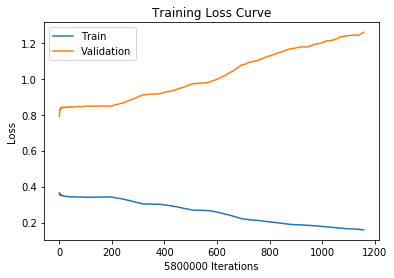

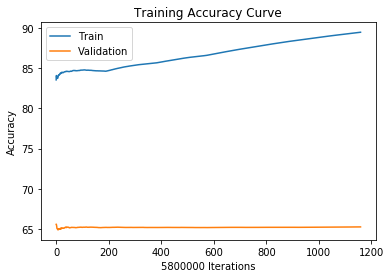

 13%|█▎        | 123422/946094 [18:00<1:51:30, 122.96it/s]

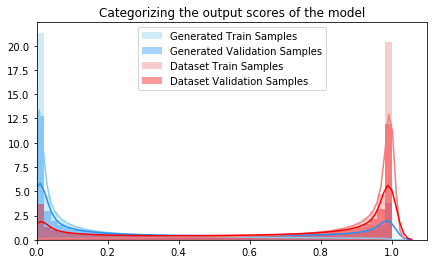

 13%|█▎        | 123453/946094 [18:26<140:52:53,  1.62it/s]

Training Accuracy at epoch 24: 89.4955172413793
Validation Accuracy epoch 24: 65.23477586206897


 18%|█▊        | 173424/946094 [25:03<2:27:02, 87.58it/s]  

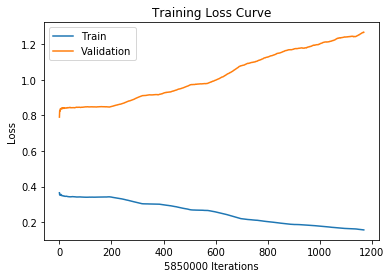

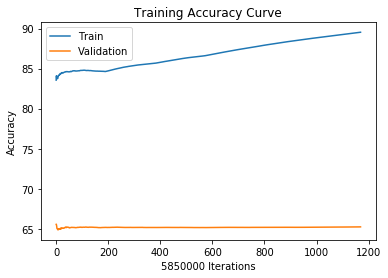

 18%|█▊        | 173424/946094 [25:20<2:27:02, 87.58it/s]

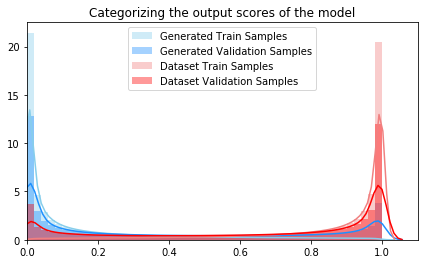

 18%|█▊        | 173454/946094 [25:46<159:47:08,  1.34it/s]

Training Accuracy at epoch 24: 89.53907692307692
Validation Accuracy epoch 24: 65.23988034188034


 24%|██▎       | 223430/946094 [32:21<1:20:49, 149.03it/s] 

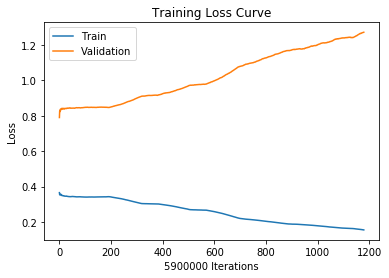

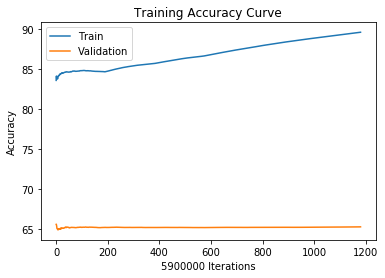

 24%|██▎       | 223430/946094 [32:40<1:20:49, 149.03it/s]

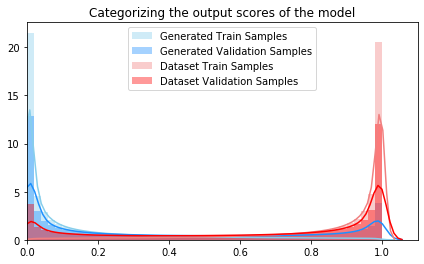

 24%|██▎       | 223454/946094 [33:02<289:15:00,  1.44s/it]

Training Accuracy at epoch 24: 89.58072881355932
Validation Accuracy epoch 24: 65.24450847457626


 29%|██▉       | 273420/946094 [39:37<1:44:57, 106.82it/s] 

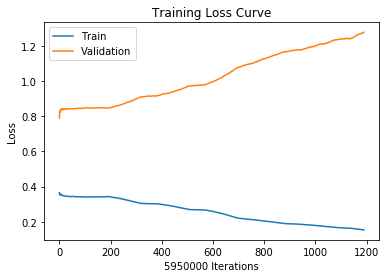

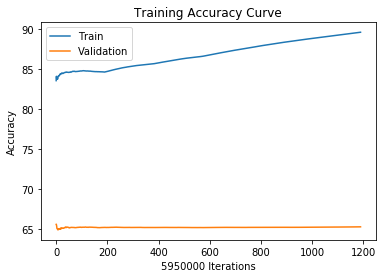

 29%|██▉       | 273420/946094 [39:50<1:44:57, 106.82it/s]

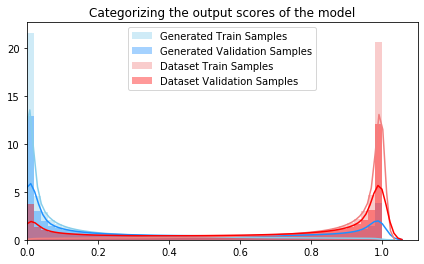

 29%|██▉       | 273454/946094 [40:20<106:22:10,  1.76it/s]

Training Accuracy at epoch 24: 89.62208403361345
Validation Accuracy epoch 24: 65.24635294117647


 34%|███▍      | 323421/946094 [46:54<1:04:49, 160.07it/s] 

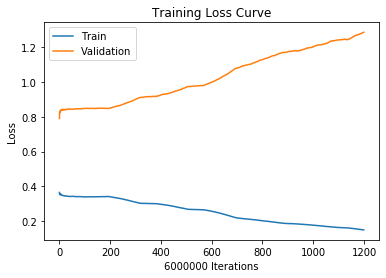

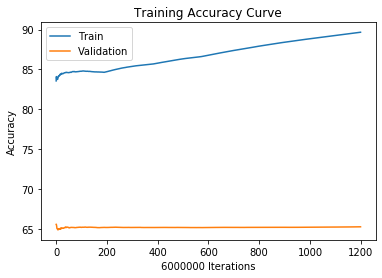

 34%|███▍      | 323421/946094 [47:10<1:04:49, 160.07it/s]

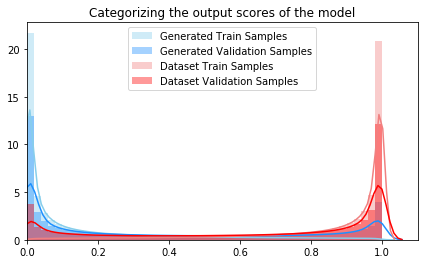

 34%|███▍      | 323453/946094 [47:37<103:19:45,  1.67it/s]

Training Accuracy at epoch 24: 89.66318333333334
Validation Accuracy epoch 24: 65.25033333333333


 39%|███▉      | 373421/946094 [54:10<1:09:54, 136.53it/s] 

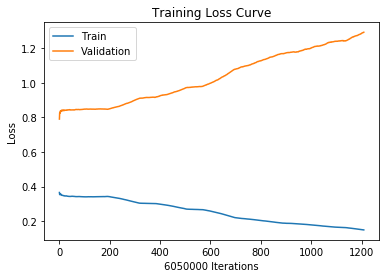

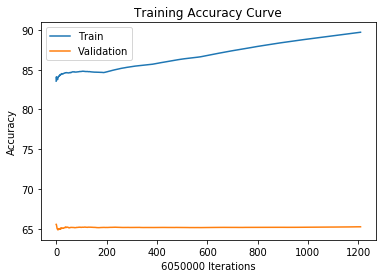

 39%|███▉      | 373421/946094 [54:30<1:09:54, 136.53it/s]

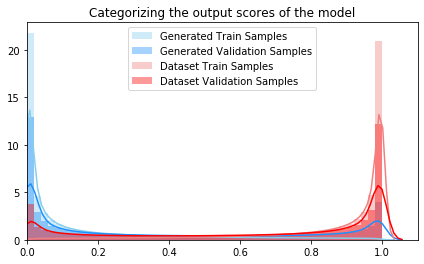

 39%|███▉      | 373454/946094 [54:53<97:17:26,  1.63it/s] 

Training Accuracy at epoch 24: 89.70357024793388
Validation Accuracy epoch 24: 65.25266115702479


 41%|████▏     | 391010/946094 [57:11<53:42, 172.23it/s]  

In [ ]:
model = SingleAlphabetComplexNet()
model_name = model.name
model_id = "06172020"
model.to(device)
checkpoint = 'model_checkpoints/binary/%s/06172020.pth' % model_name
save_path = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
single_alphabet = True
cdf=False
NUM_EPOCHS = 50
BATCH_SIZE = 128
gamma = 1e-1
classifier(model, binary_train, binary_val, gamma, model_id, NUM_EPOCHS, BATCH_SIZE, single_alphabet, checkpoint, save_path, cdf=cdf)